# Setting

In [1]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from models.shared_perceiver import CustomDataset, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정

def seed_worker(worker_id): #데이터로더 난수고정
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(42)
g = torch.Generator()
g.manual_seed(42)
NUM_WORKERS = 4 # 서브프로세스관리자 수. 난수생성과 관련있습니다. 일단은 4로 고정합니다.


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


# Functions

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)
        #print(f"🚀 input_ids.shape: {input_ids.shape}") 
        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        #print(f"🚀 outputs.shape: {outputs.shape}")
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
model_path = '/home/Minju/Perceiver/shared_layer_model'
loader_path = '/home/Minju/Perceiver/loader'

In [7]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False, 
                            num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
    first_batch = next(iter(dataloader))
    print(first_batch)
 


group 1 처리 중...
{'input_ids': tensor([ 101, 1996, 2317, 2160, 2003, 1037, 4556, 2806, 3538, 1997, 4294, 1010,
        4427, 2011, 3306, 1998, 3142, 3121, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0,

# Train 시작


group 1 처리 중...

  fold 1/5 처리 중...
    epoch 1/40: train loss: 0.9961, train acc: 0.4545
                               test loss: 0.8122, test acc: 0.6008
    epoch 5/40: train loss: 0.6654, train acc: 0.7049
                               test loss: 0.7623, test acc: 0.6351
    epoch 10/40: train loss: 0.2985, train acc: 0.9056
                               test loss: 0.4593, test acc: 0.8320
    epoch 15/40: train loss: 0.2104, train acc: 0.9386
                               test loss: 0.5398, test acc: 0.8306
    epoch 20/40: train loss: 0.1779, train acc: 0.9506
                               test loss: 0.5898, test acc: 0.8258
    epoch 25/40: train loss: 0.1614, train acc: 0.9571
                               test loss: 0.6337, test acc: 0.8251
    epoch 30/40: train loss: 0.1537, train acc: 0.9604
                               test loss: 0.6324, test acc: 0.8313
    epoch 35/40: train loss: 0.1496, train acc: 0.9624
                               test loss: 0.6520, test a

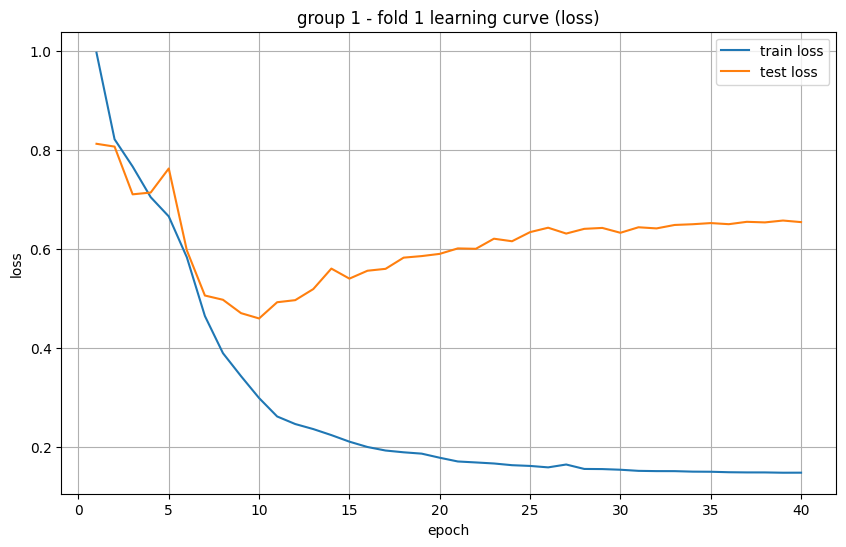

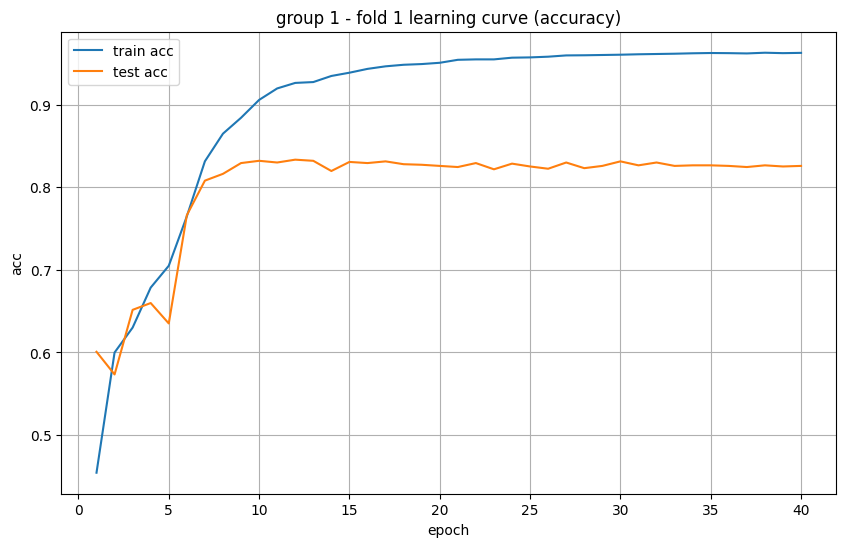

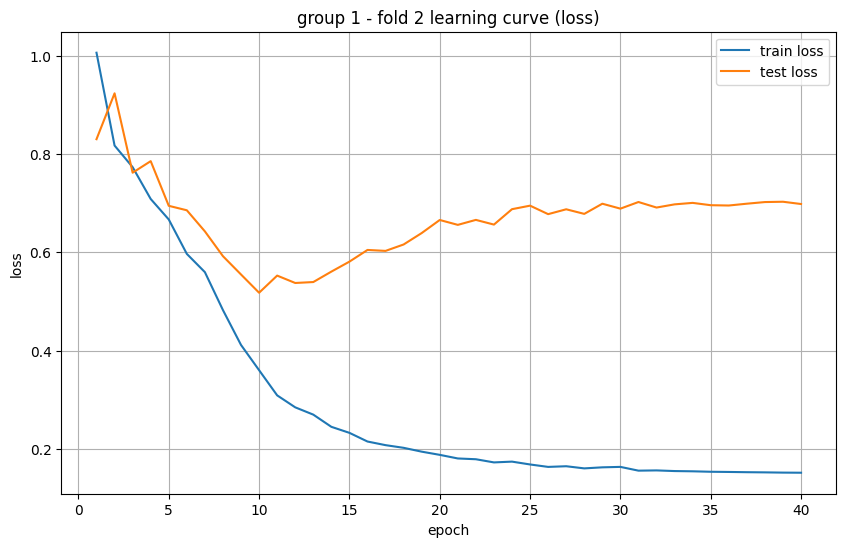

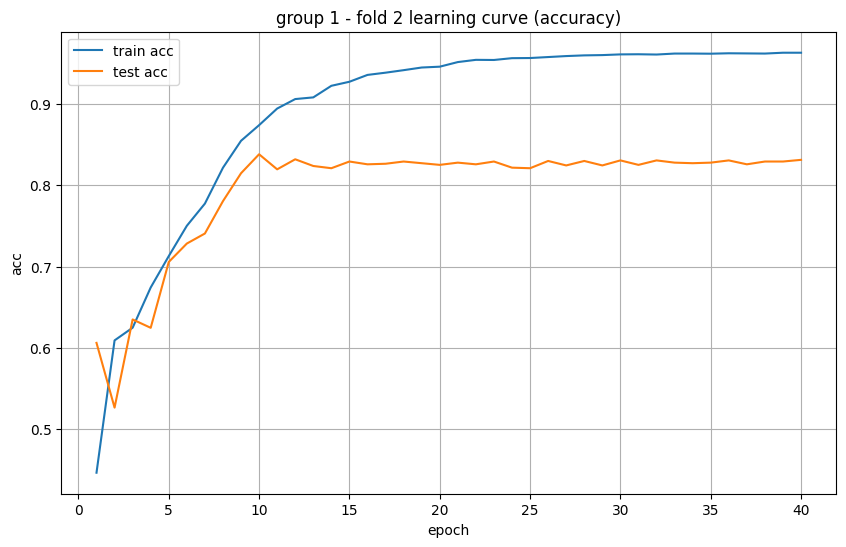

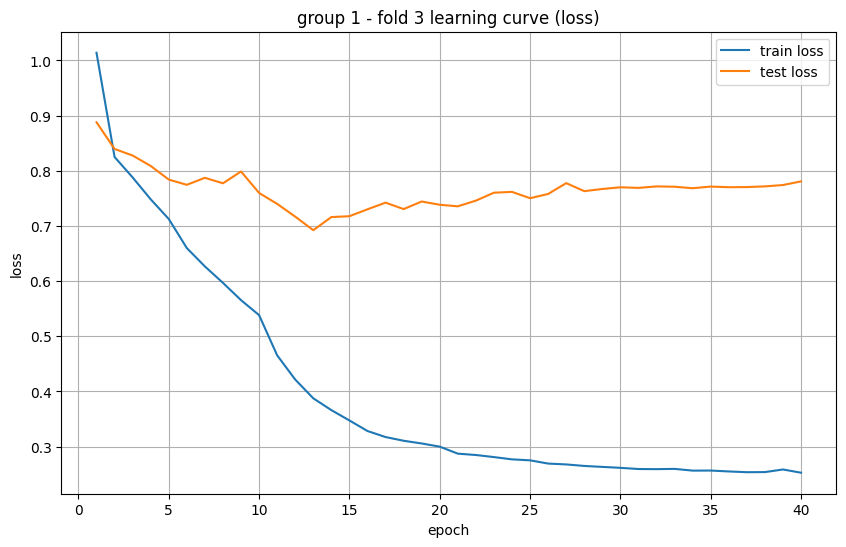

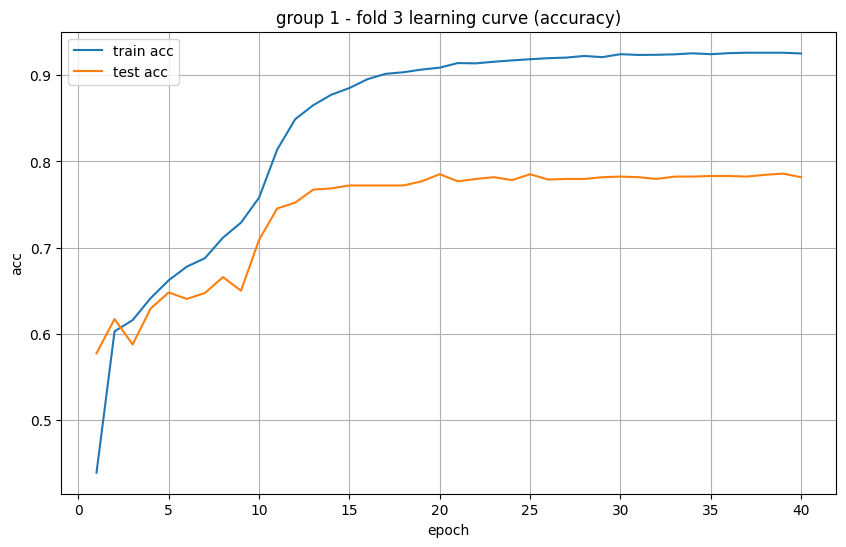

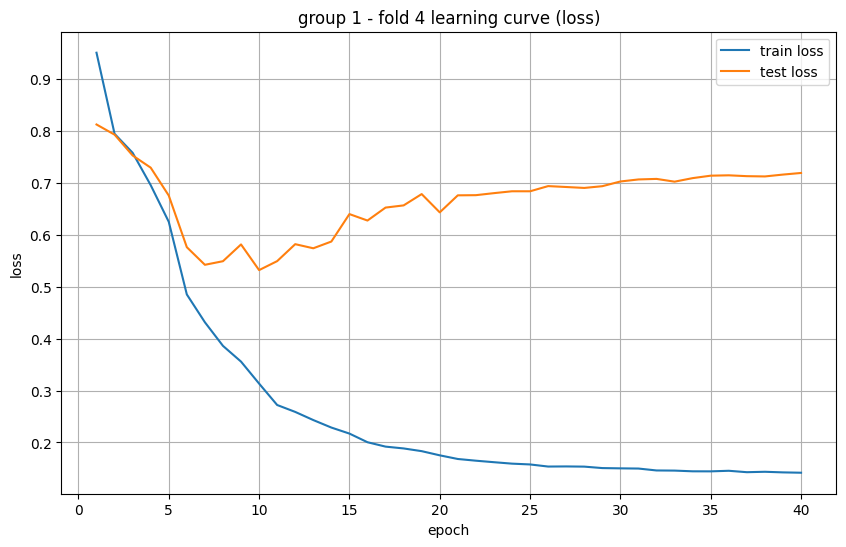

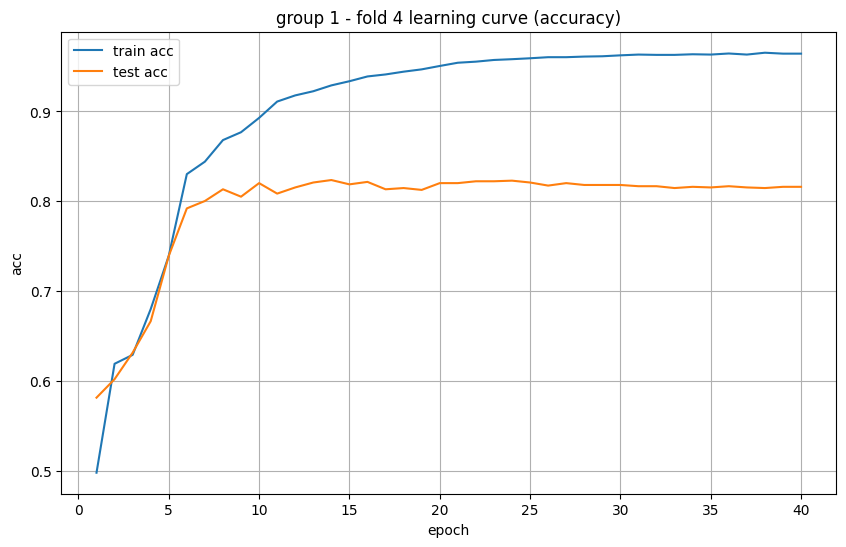

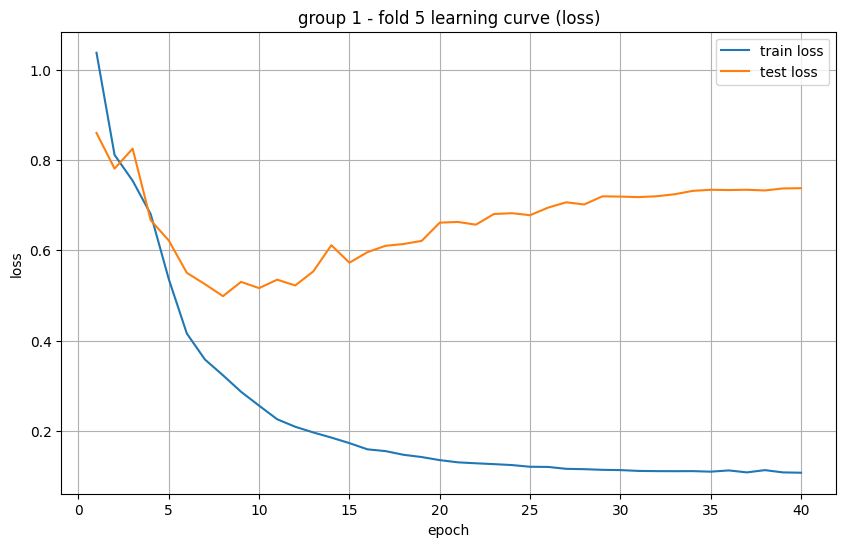

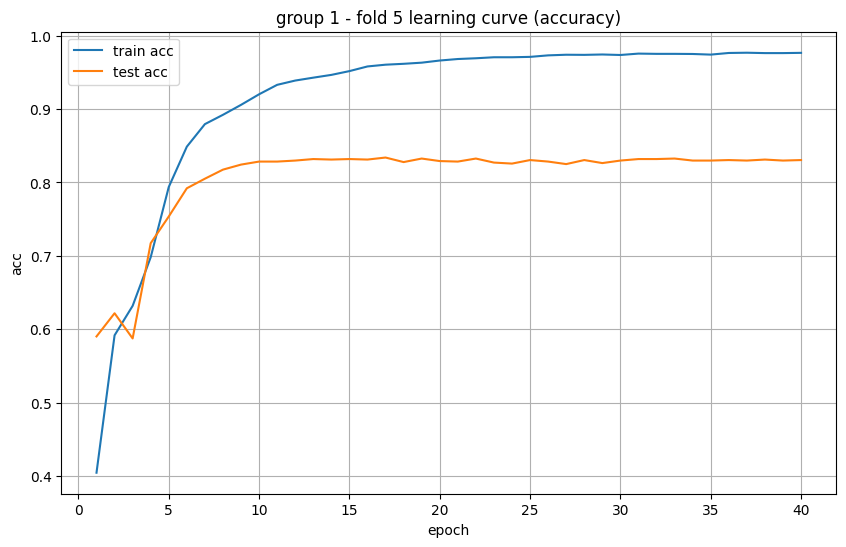

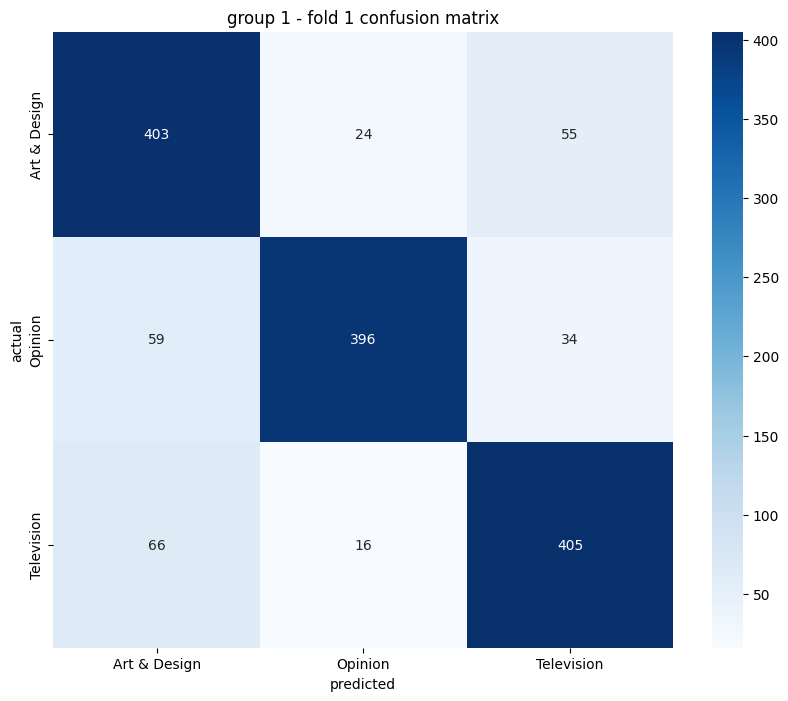

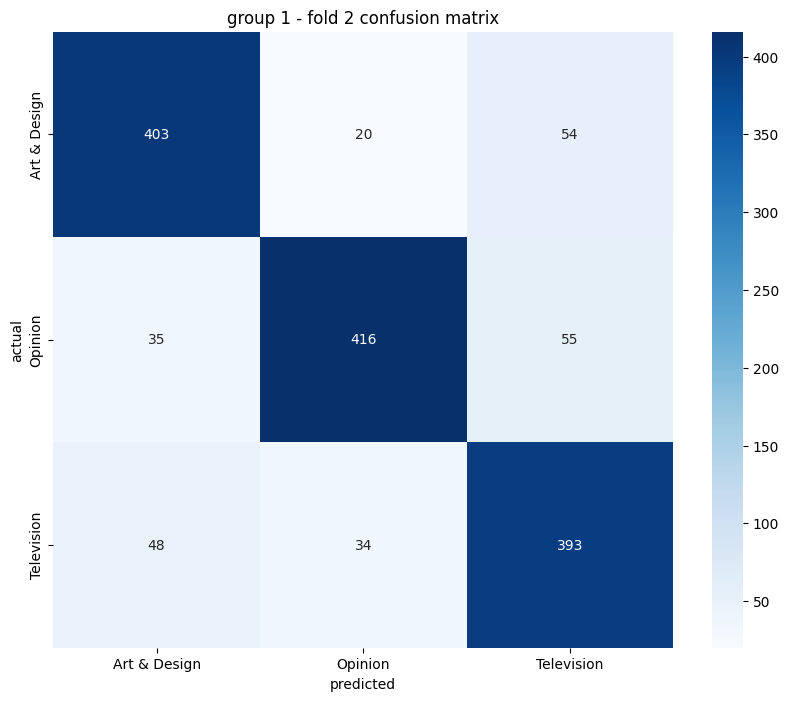

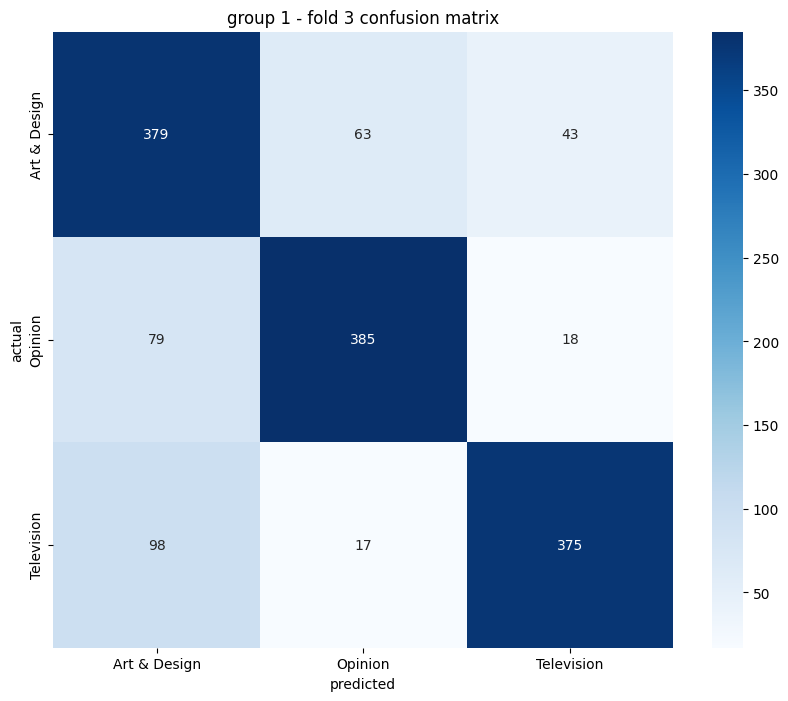

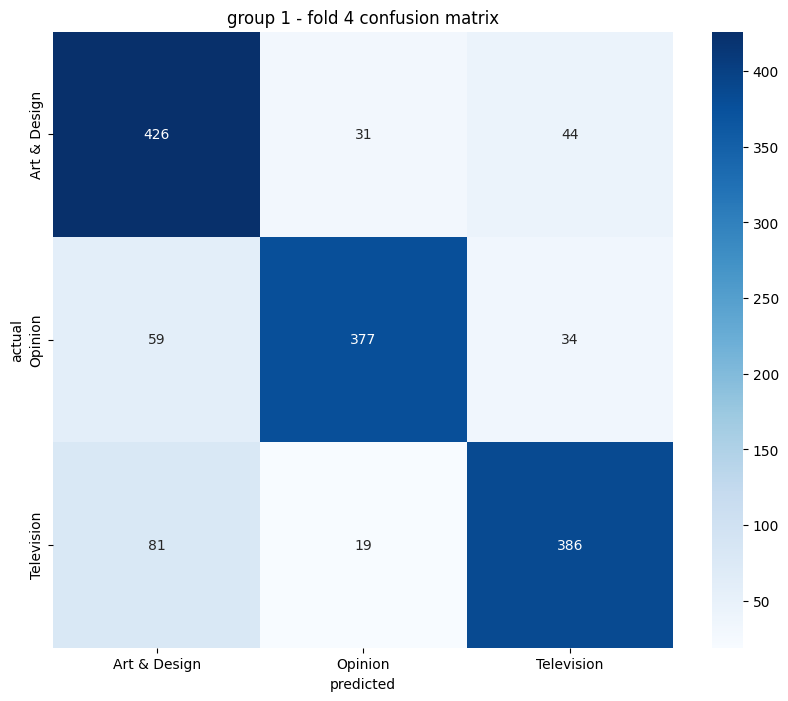

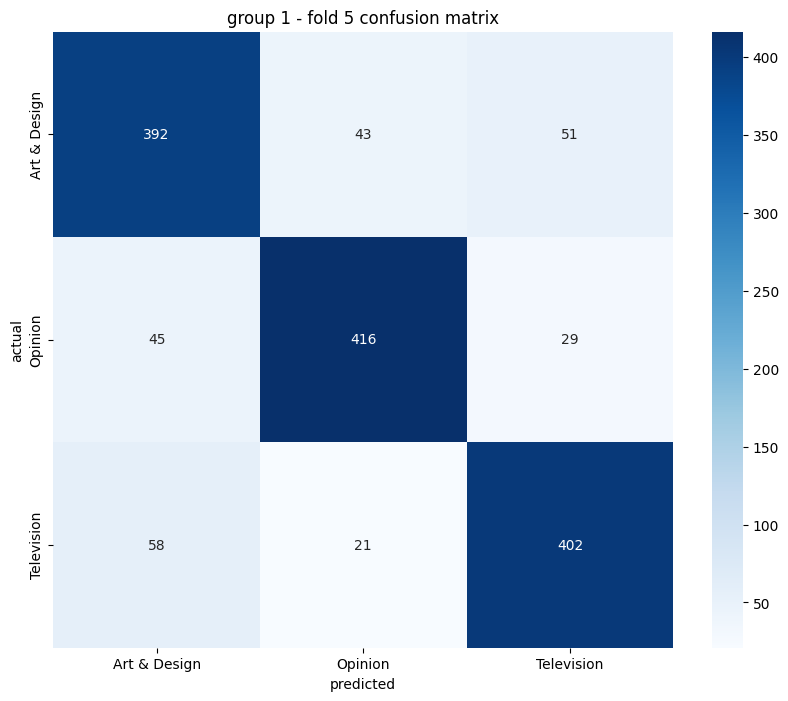


group 2 처리 중...

  fold 1/5 처리 중...
    epoch 1/40: train loss: 1.0681, train acc: 0.3924
                               test loss: 0.9732, test acc: 0.5183
    epoch 5/40: train loss: 0.6561, train acc: 0.7507
                               test loss: 0.7317, test acc: 0.6977
    epoch 10/40: train loss: 0.3795, train acc: 0.8704
                               test loss: 0.7494, test acc: 0.7302
    epoch 15/40: train loss: 0.2717, train acc: 0.9177
                               test loss: 0.7710, test acc: 0.7702
    epoch 20/40: train loss: 0.2347, train acc: 0.9330
                               test loss: 0.8085, test acc: 0.7736
    epoch 25/40: train loss: 0.2127, train acc: 0.9382
                               test loss: 0.8666, test acc: 0.7654
    epoch 30/40: train loss: 0.2037, train acc: 0.9441
                               test loss: 0.8592, test acc: 0.7702
    epoch 35/40: train loss: 0.2001, train acc: 0.9451
                               test loss: 0.8833, test a

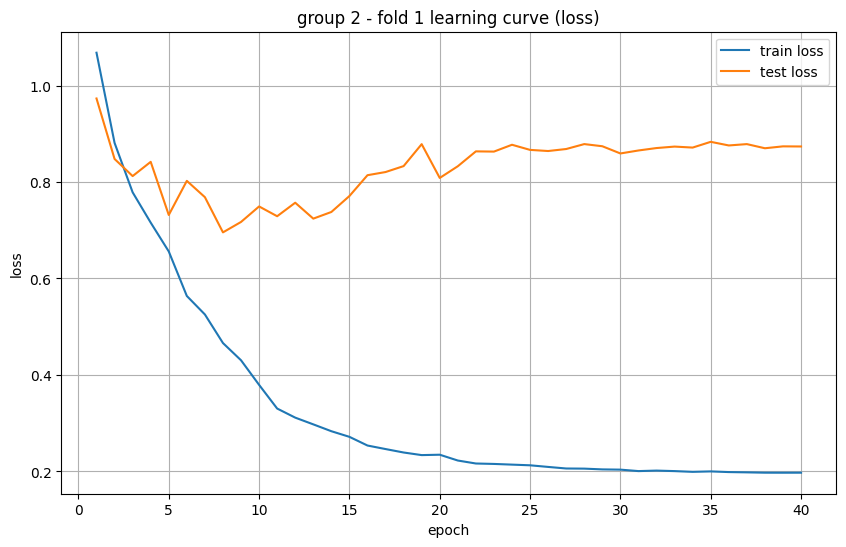

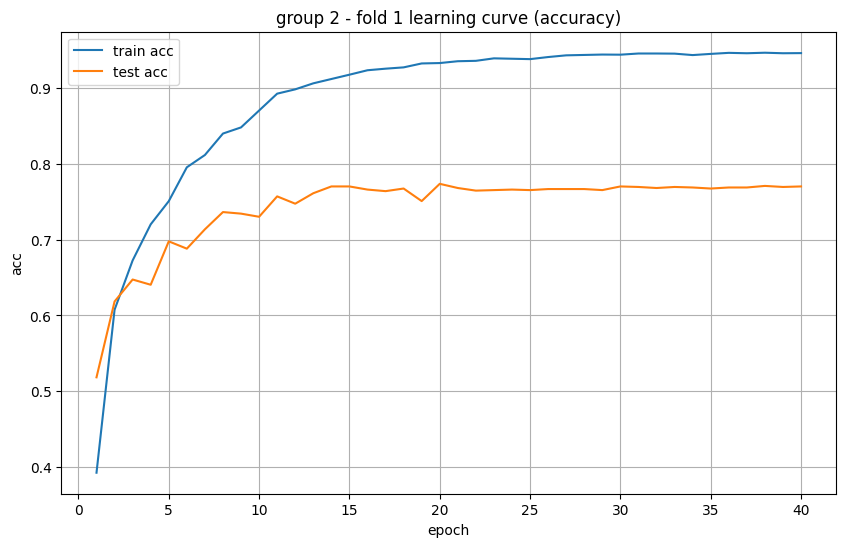

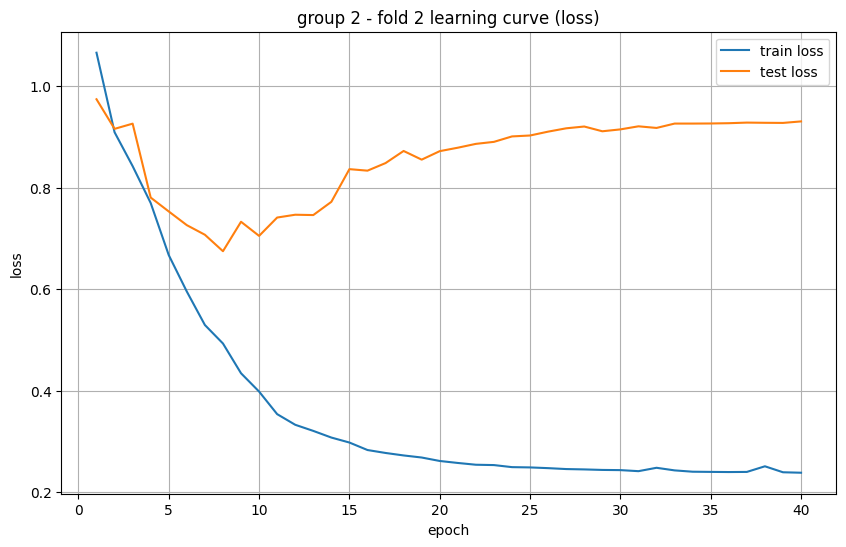

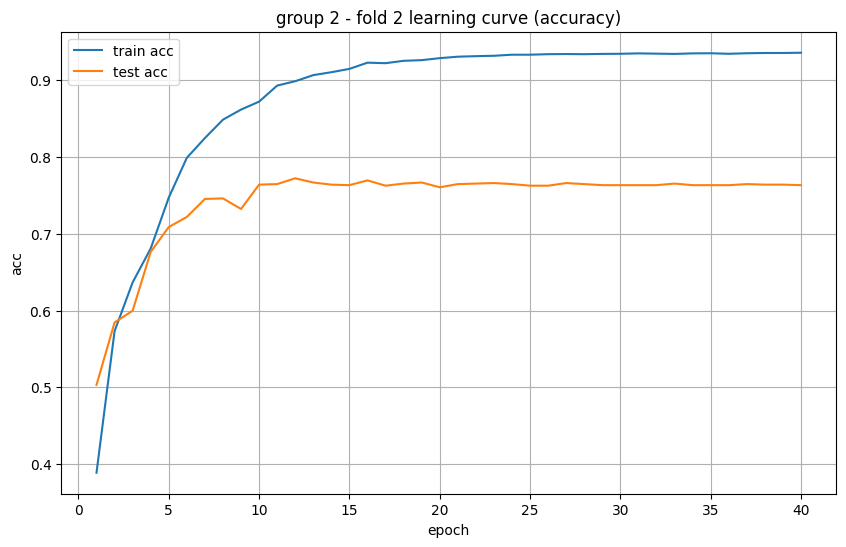

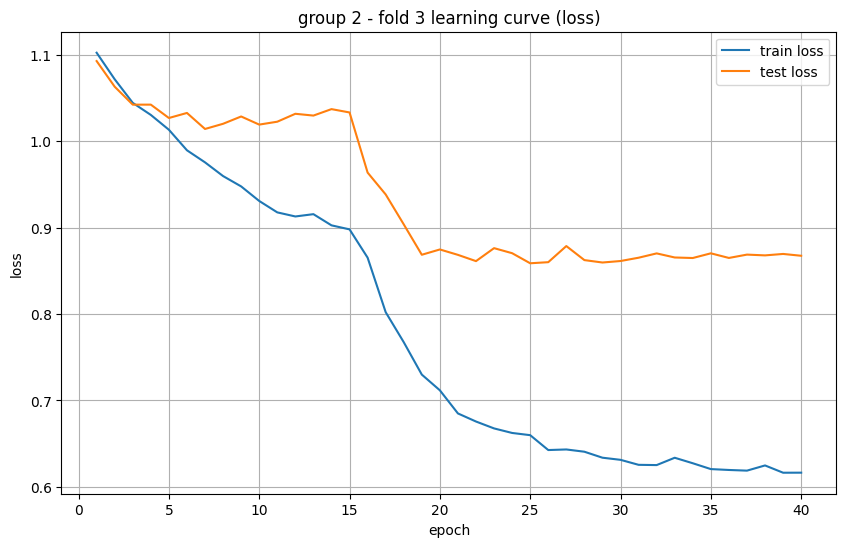

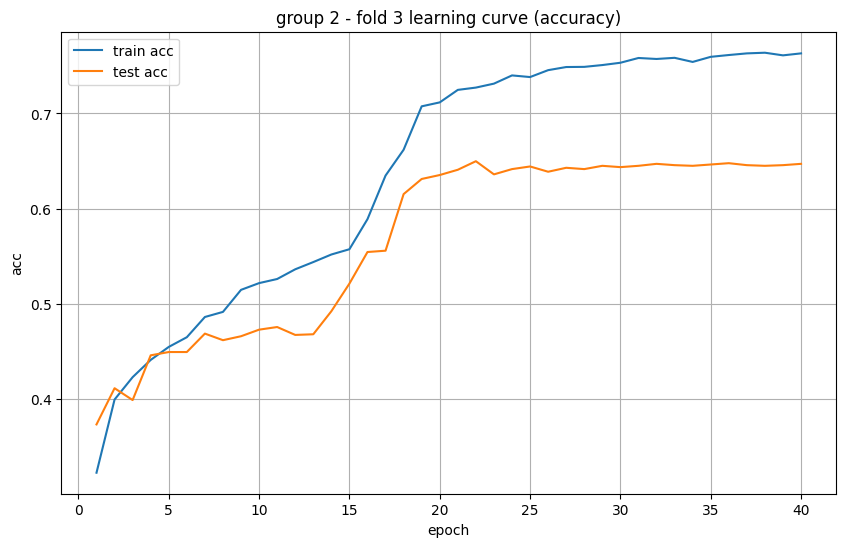

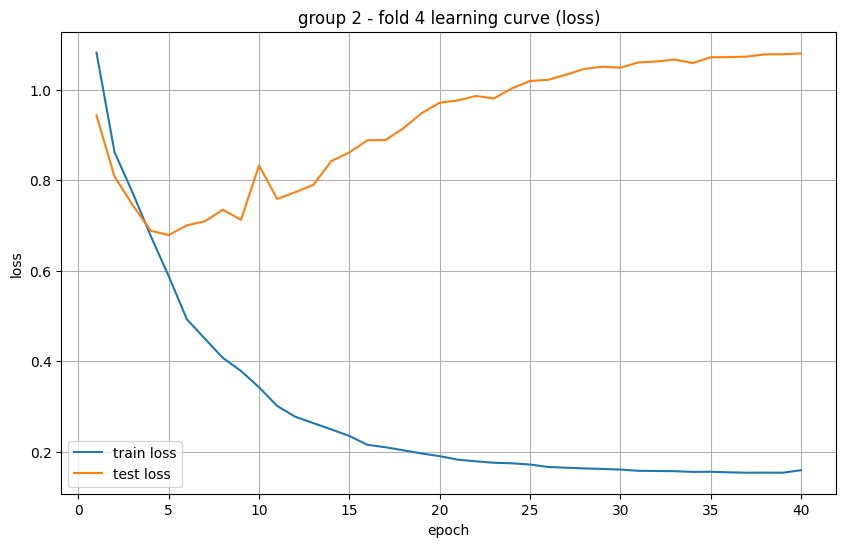

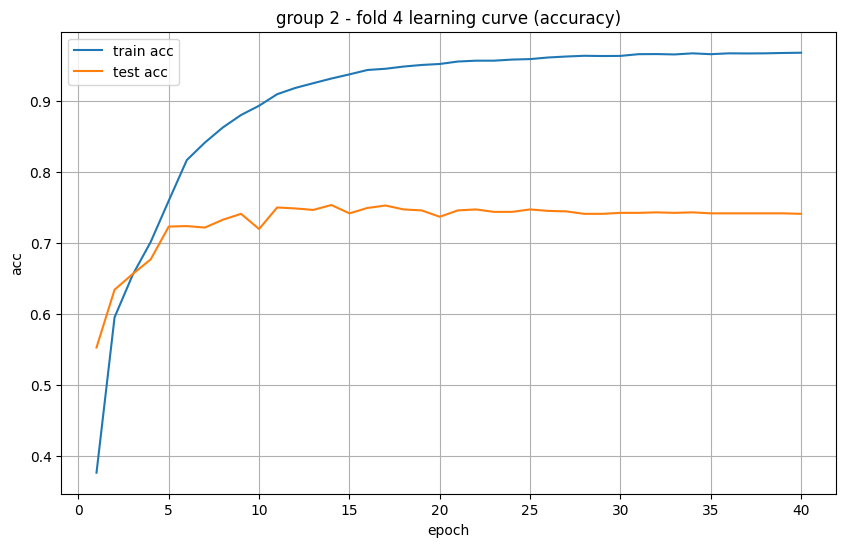

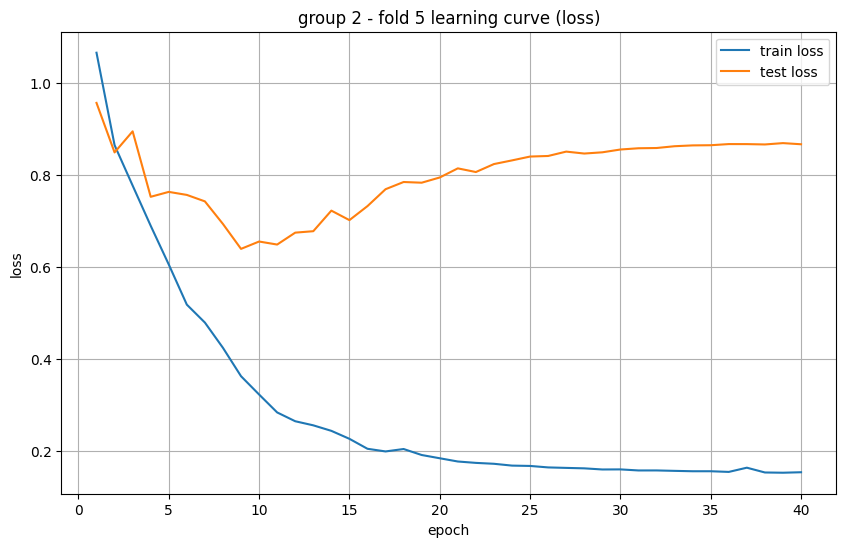

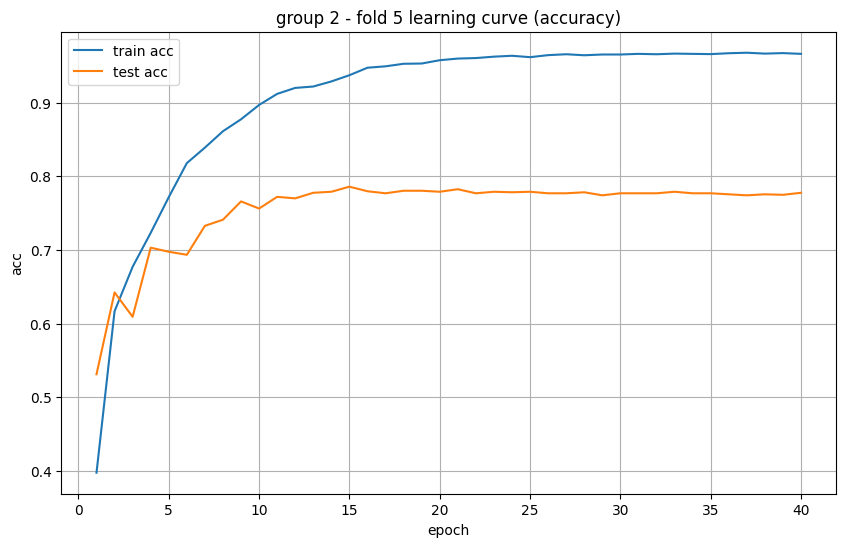

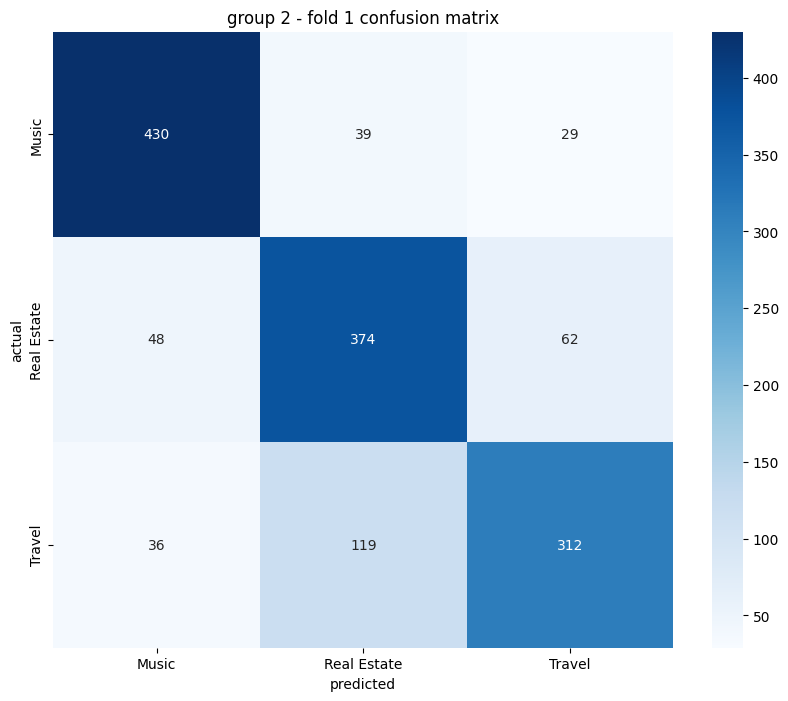

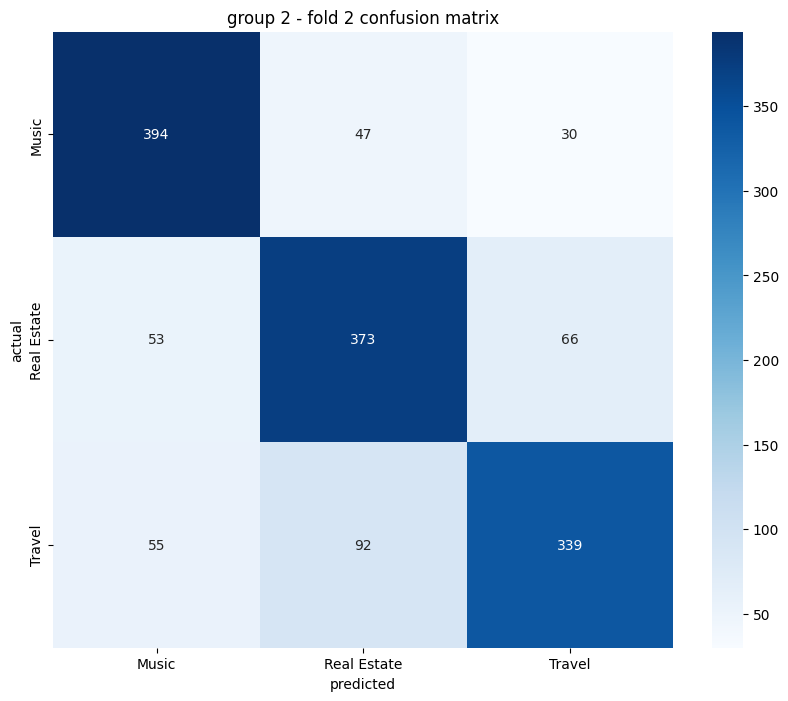

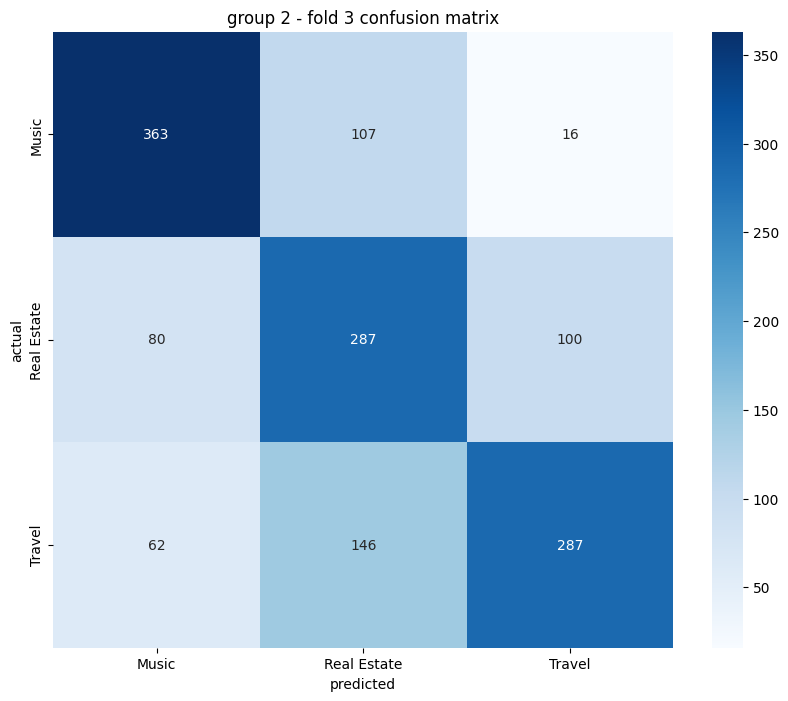

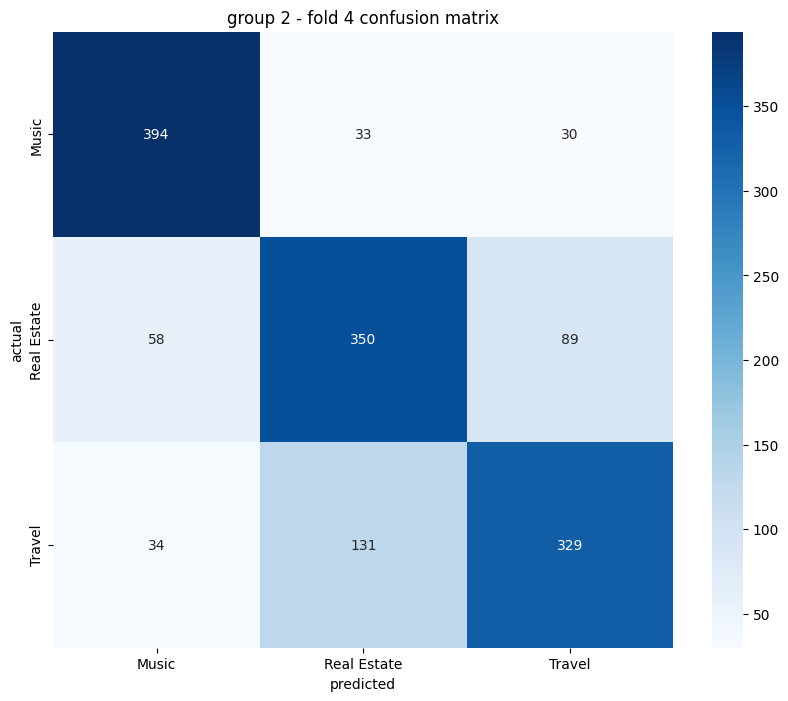

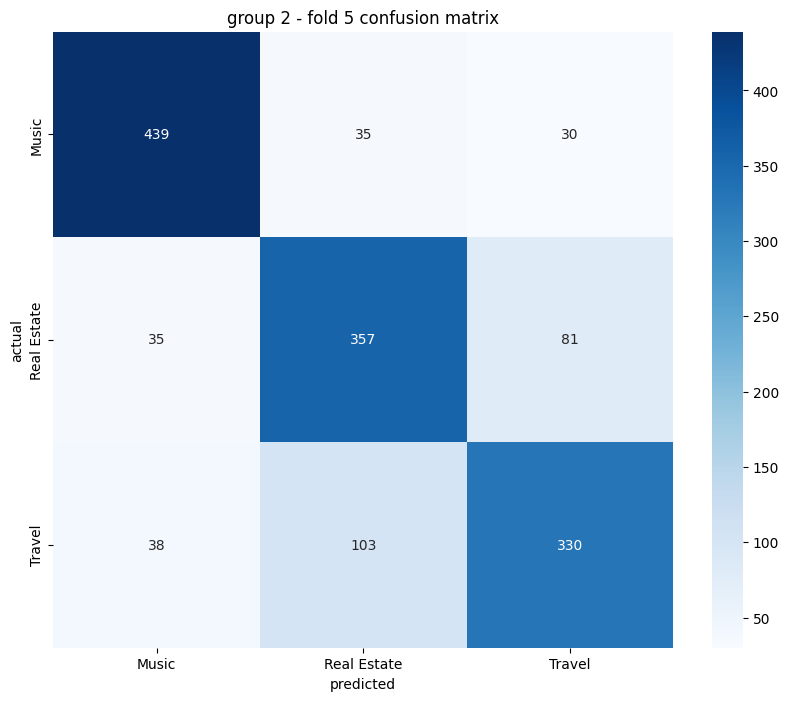


group 3 처리 중...

  fold 1/5 처리 중...
    epoch 1/40: train loss: 1.0672, train acc: 0.3871
                               test loss: 1.0010, test acc: 0.4620
    epoch 5/40: train loss: 0.5153, train acc: 0.7998
                               test loss: 0.5958, test acc: 0.7711
    epoch 10/40: train loss: 0.2745, train acc: 0.9179
                               test loss: 0.6378, test acc: 0.8029
    epoch 15/40: train loss: 0.1987, train acc: 0.9440
                               test loss: 0.6359, test acc: 0.8043
    epoch 20/40: train loss: 0.1590, train acc: 0.9606
                               test loss: 0.7386, test acc: 0.7939
    epoch 25/40: train loss: 0.1409, train acc: 0.9682
                               test loss: 0.7886, test acc: 0.7960
    epoch 30/40: train loss: 0.1344, train acc: 0.9694
                               test loss: 0.8095, test acc: 0.7905
    epoch 35/40: train loss: 0.1291, train acc: 0.9720
                               test loss: 0.8133, test a

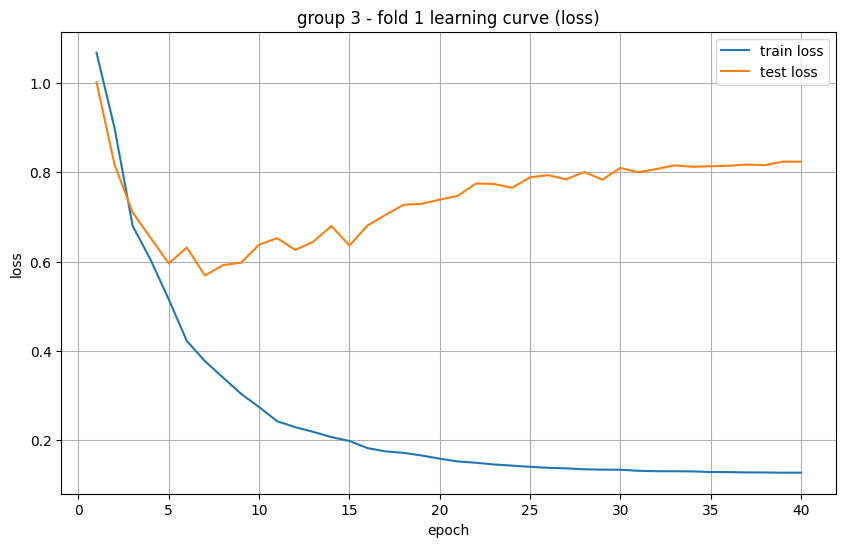

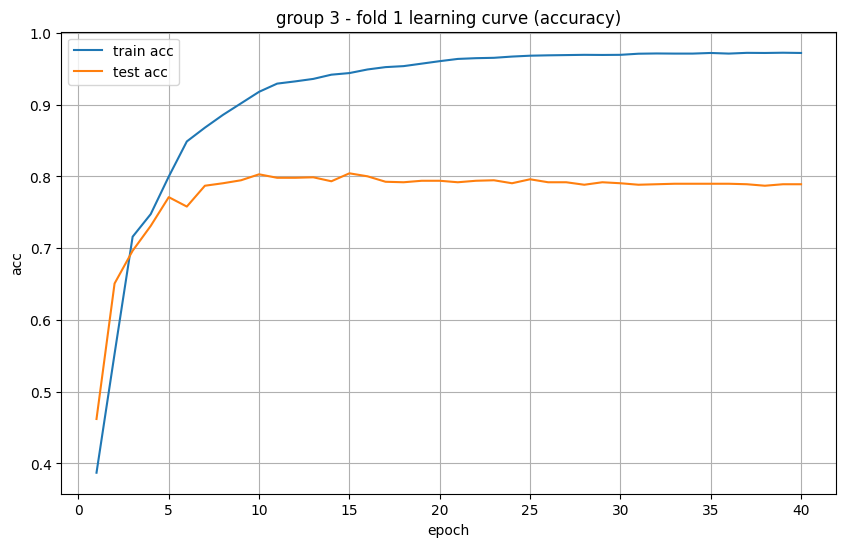

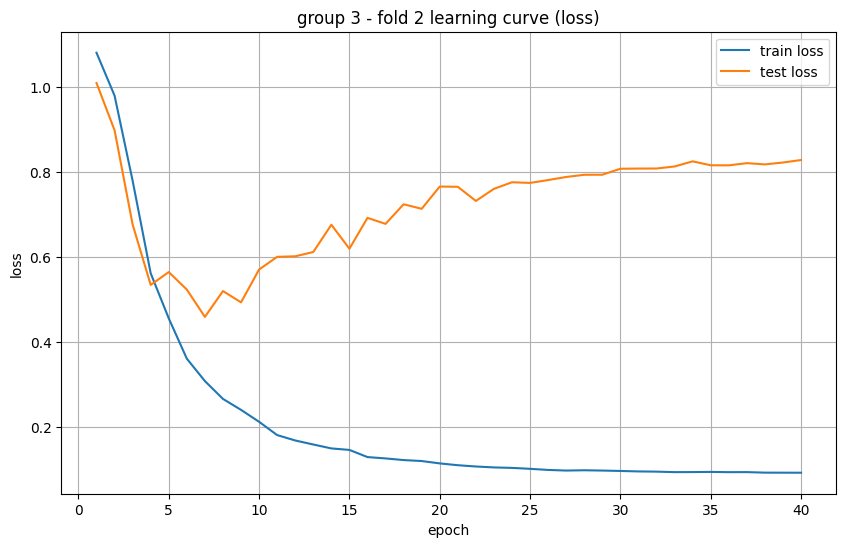

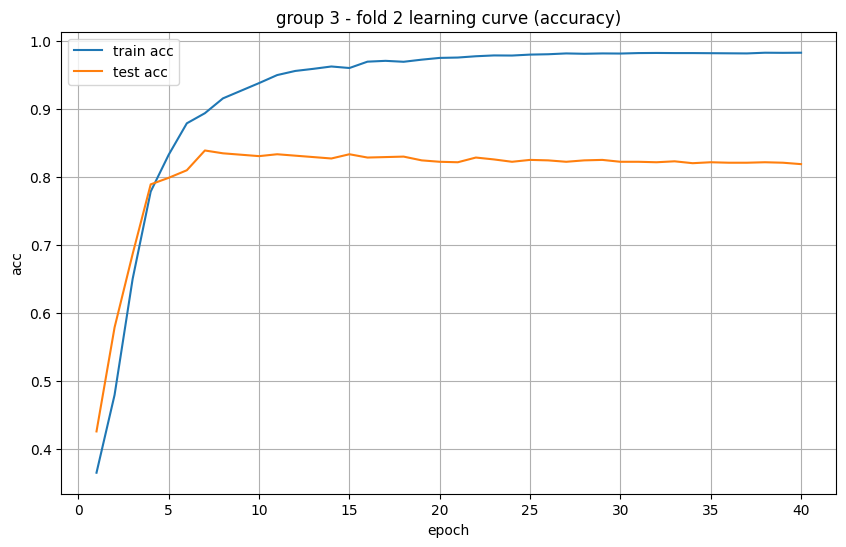

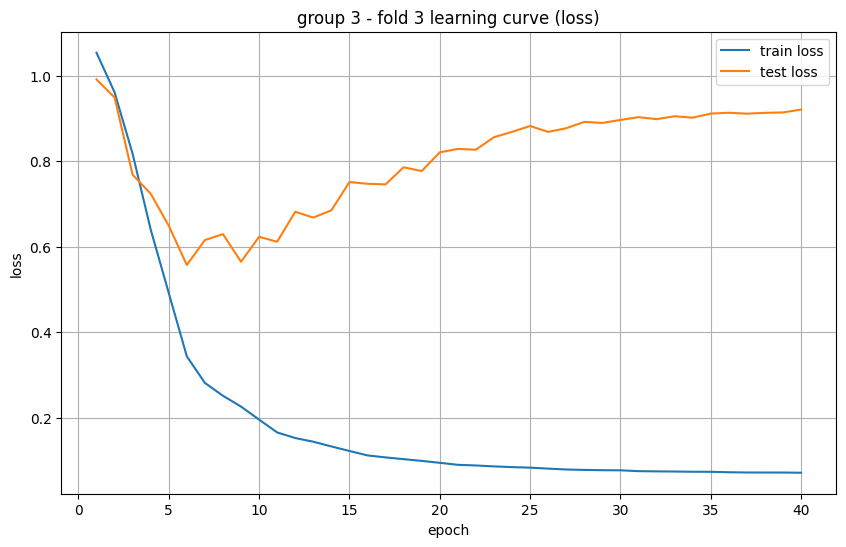

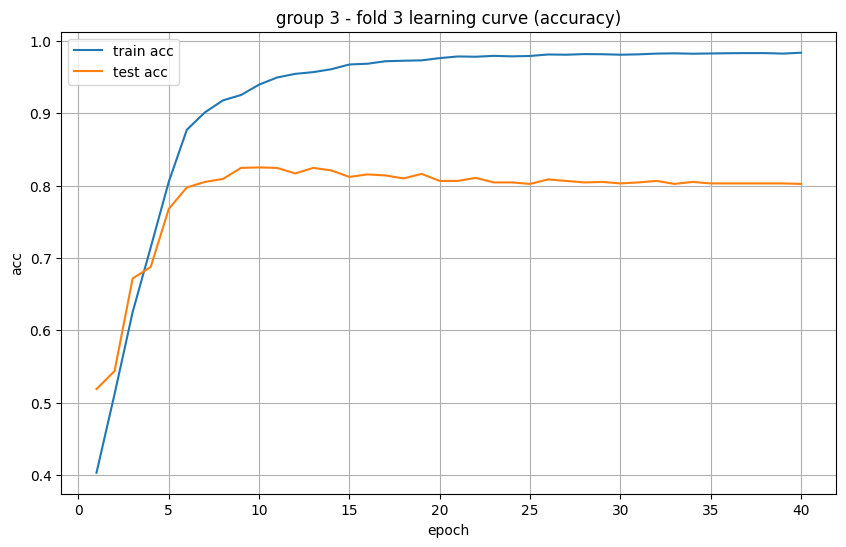

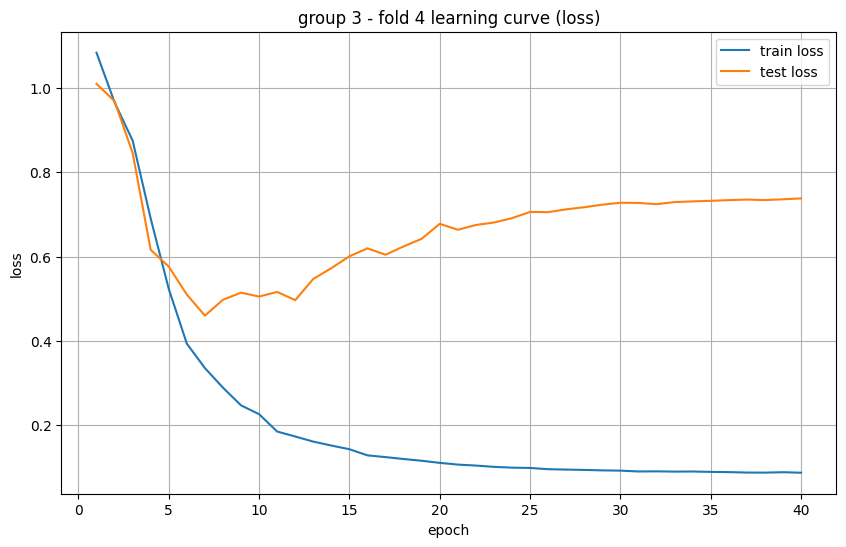

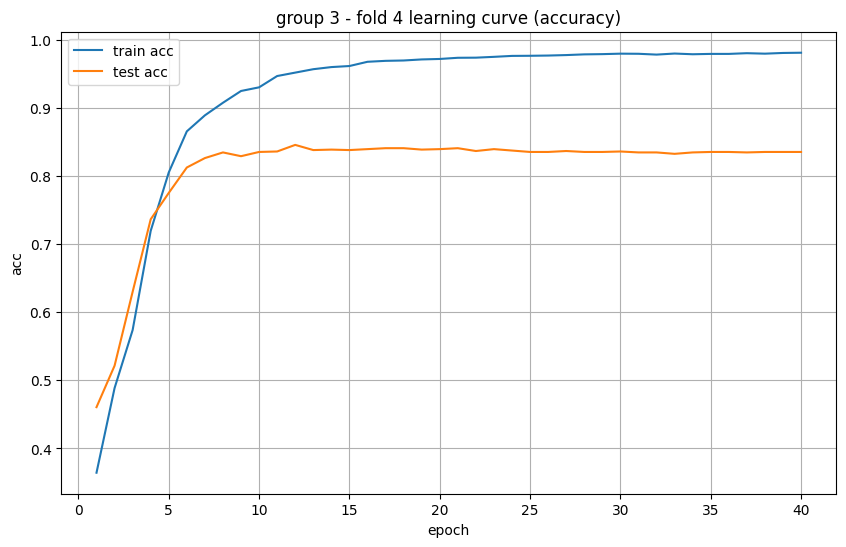

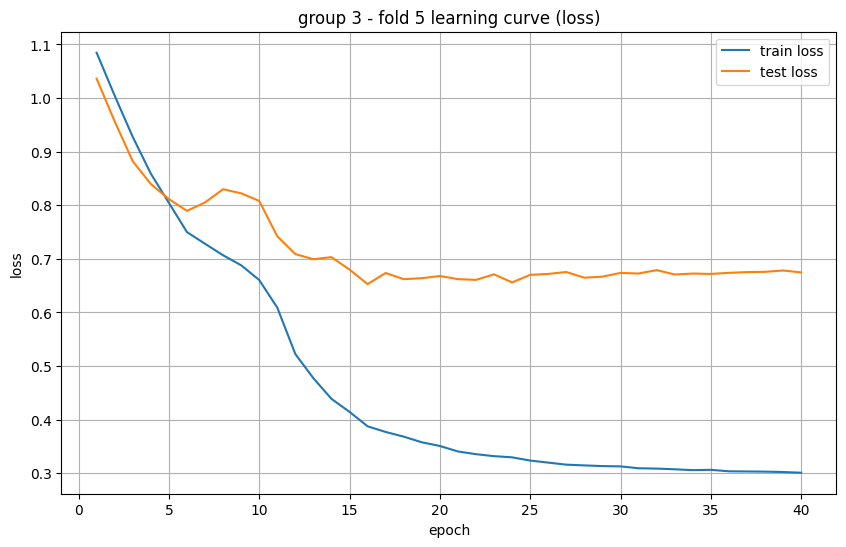

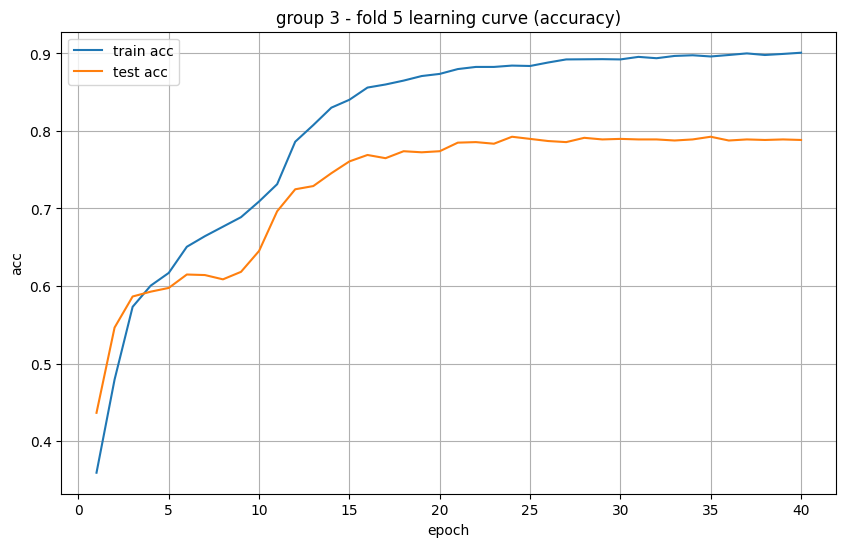

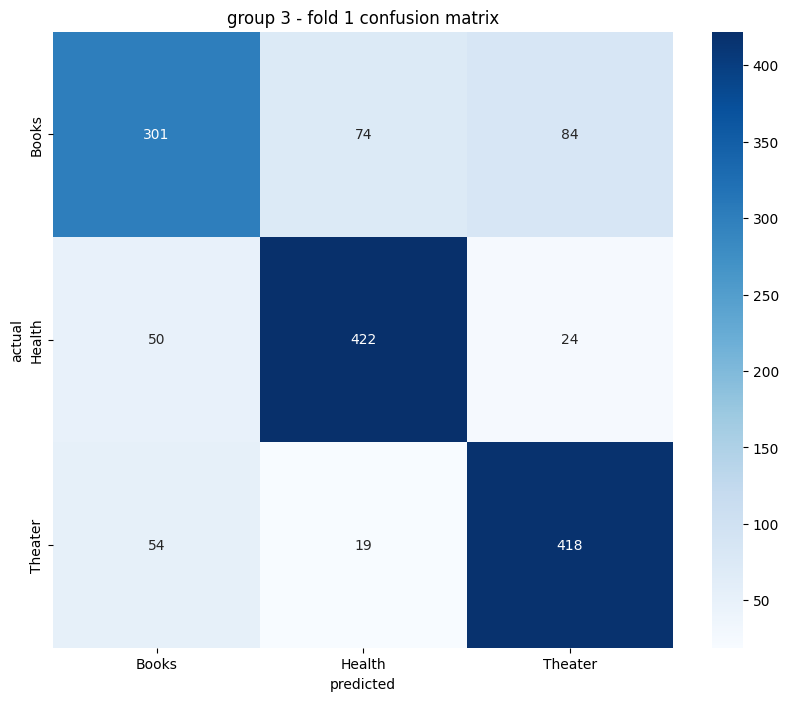

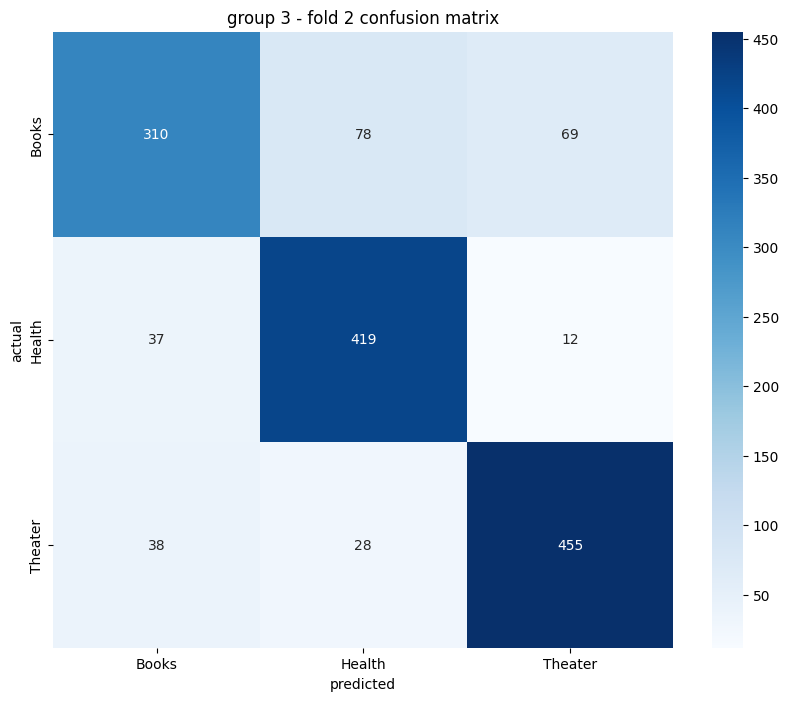

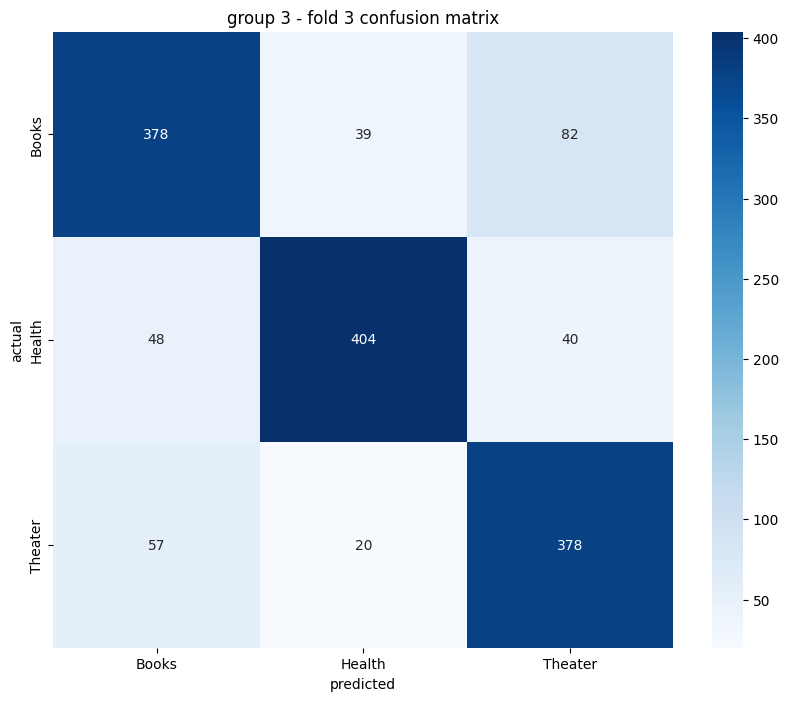

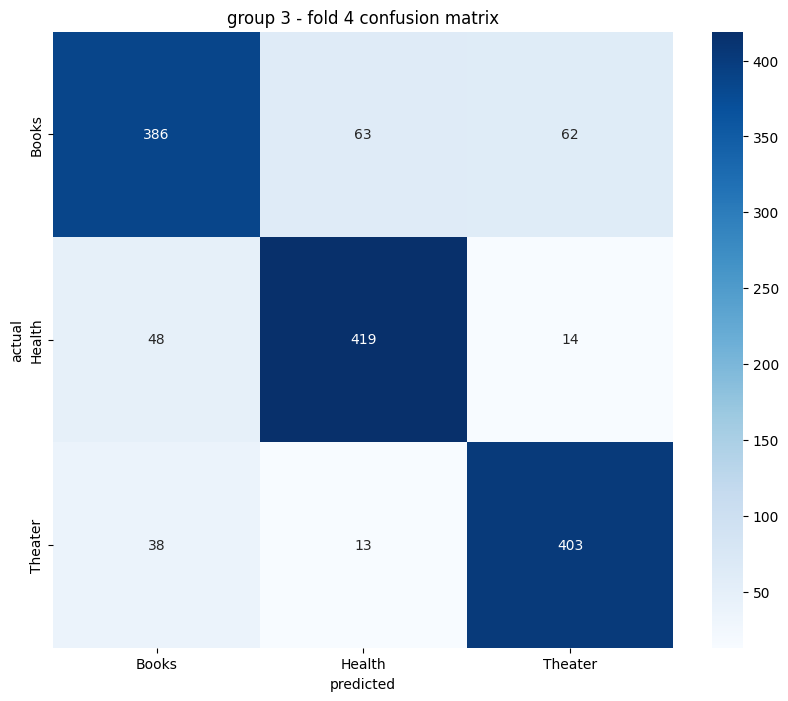

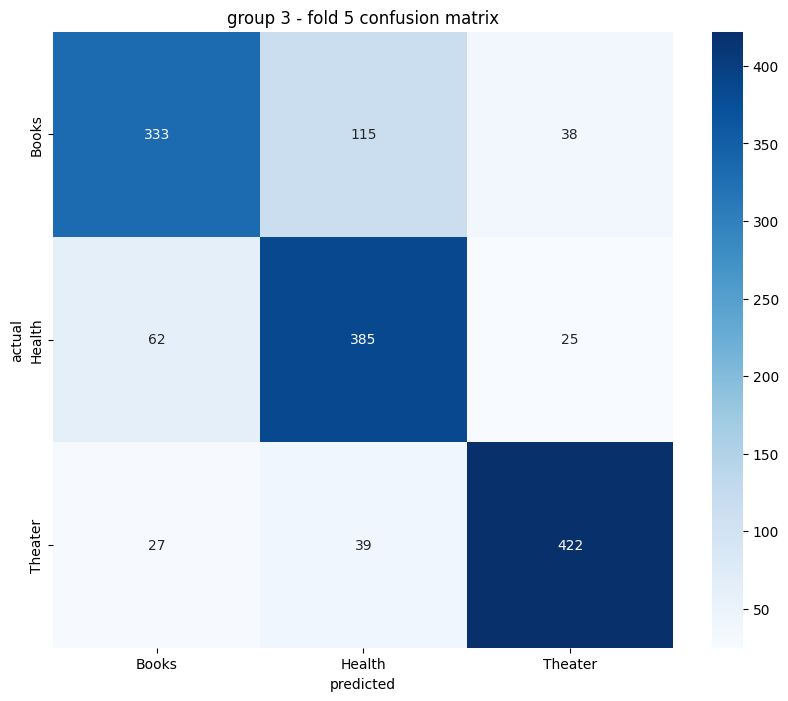


group 4 처리 중...

  fold 1/5 처리 중...
    epoch 1/40: train loss: 1.0814, train acc: 0.3850
                               test loss: 1.0431, test acc: 0.4464
    epoch 5/40: train loss: 0.9379, train acc: 0.5177
                               test loss: 0.9882, test acc: 0.4819
    epoch 10/40: train loss: 0.8597, train acc: 0.5596
                               test loss: 1.0366, test acc: 0.4937
    epoch 15/40: train loss: 0.8170, train acc: 0.5727
                               test loss: 1.1113, test acc: 0.4937
    epoch 20/40: train loss: 0.7972, train acc: 0.5807
                               test loss: 1.1515, test acc: 0.4909
    epoch 25/40: train loss: 0.7874, train acc: 0.5842
                               test loss: 1.1738, test acc: 0.4909
    epoch 30/40: train loss: 0.7824, train acc: 0.5854
                               test loss: 1.1817, test acc: 0.4882
    epoch 35/40: train loss: 0.7802, train acc: 0.5861
                               test loss: 1.1863, test a

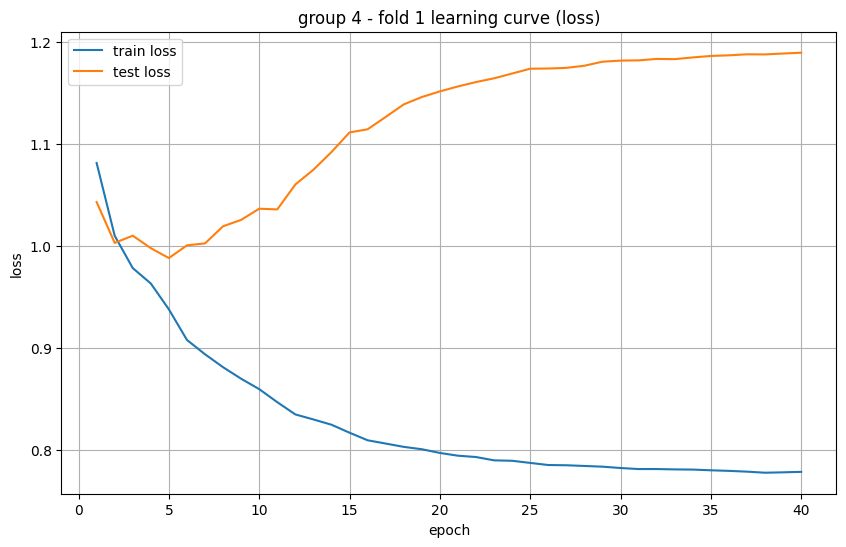

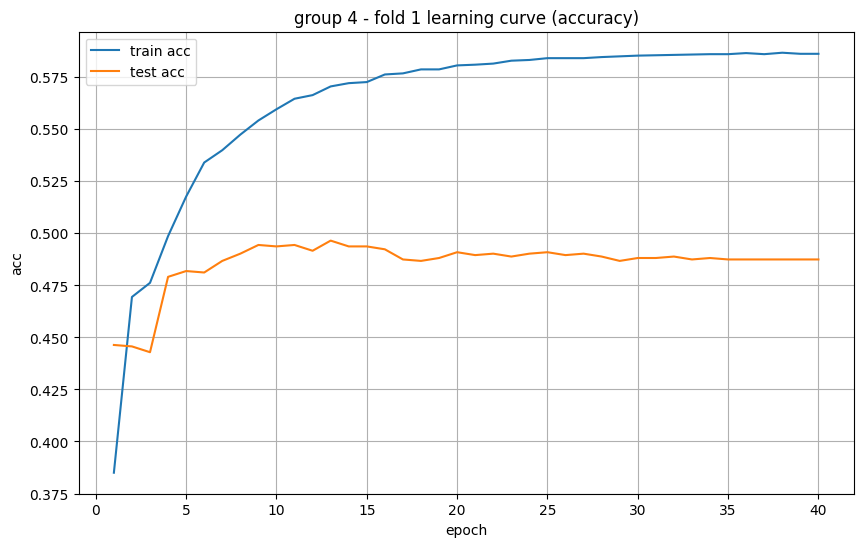

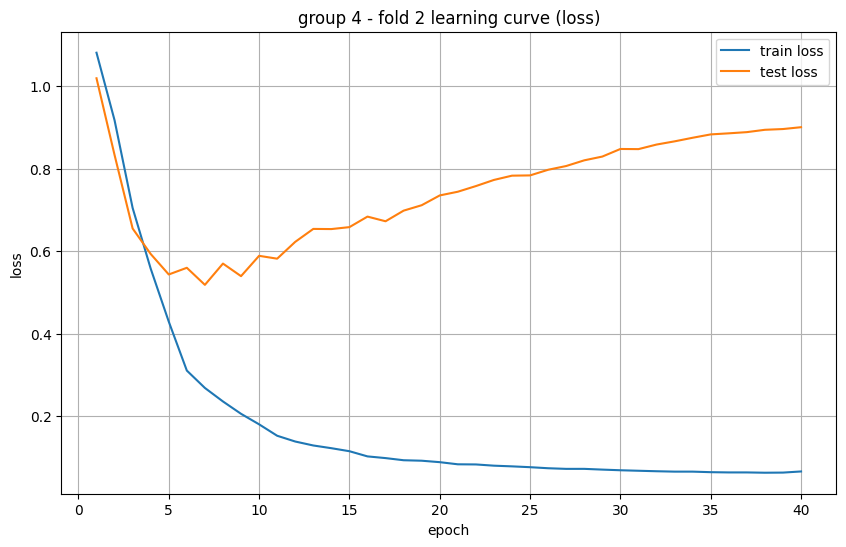

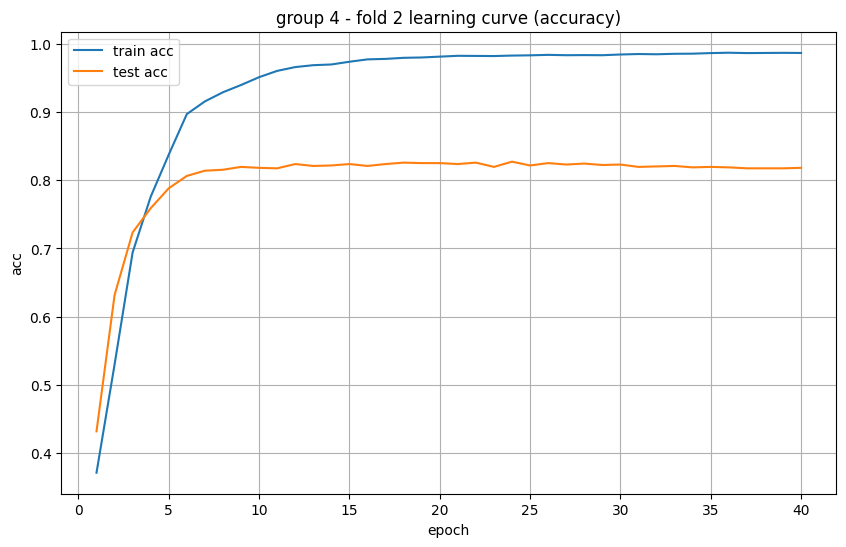

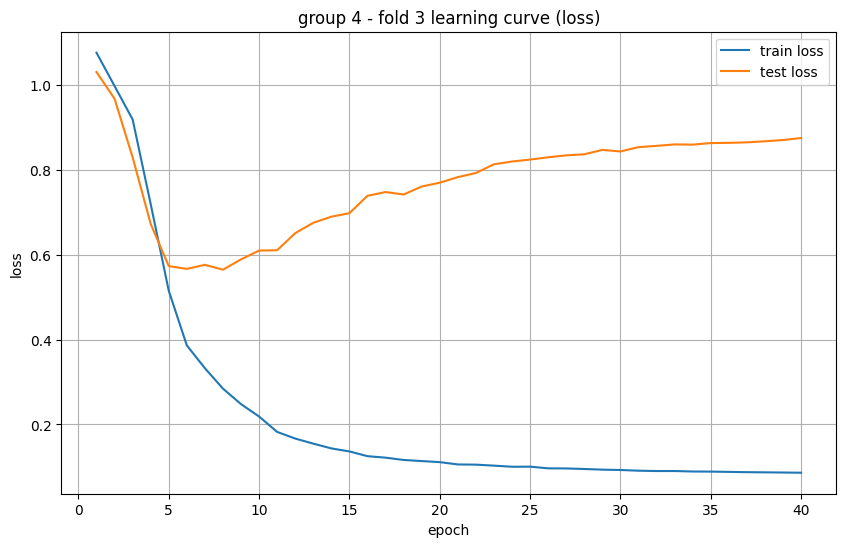

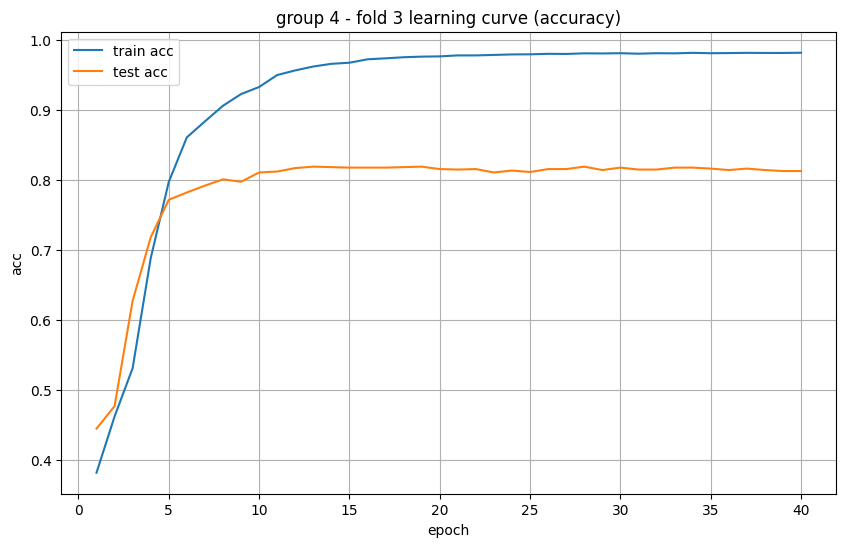

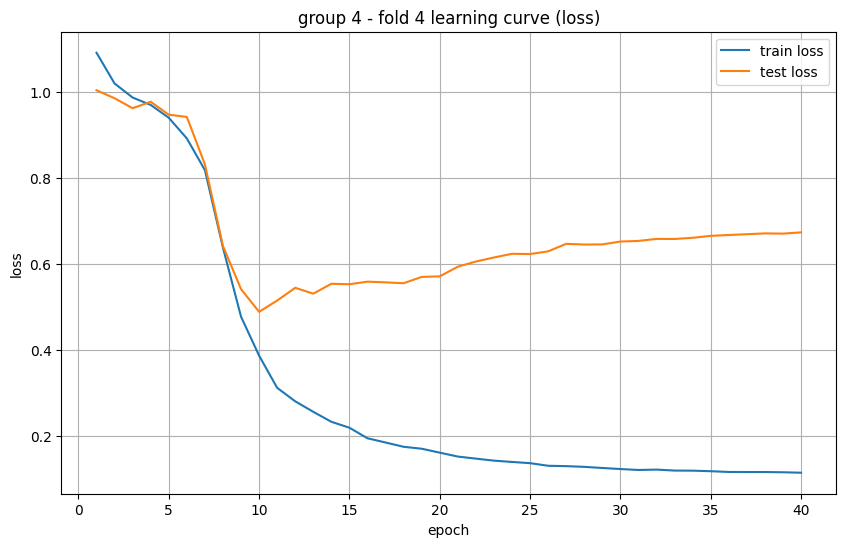

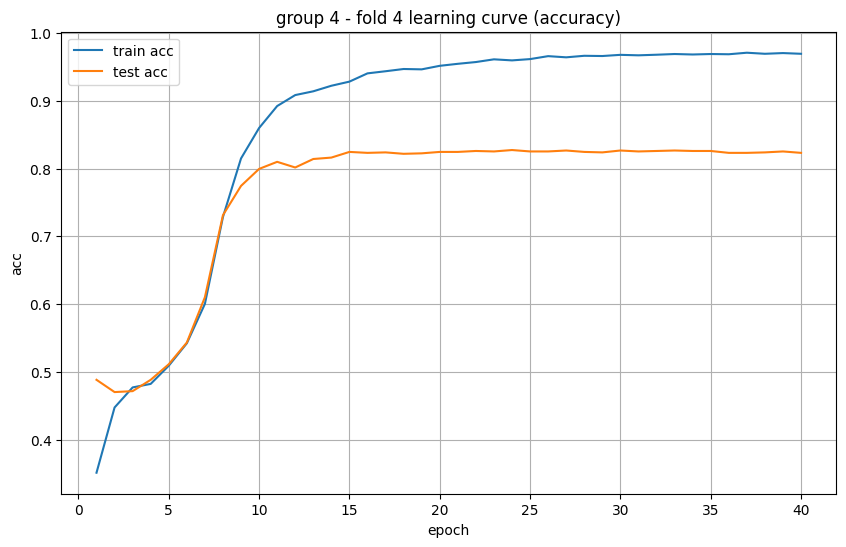

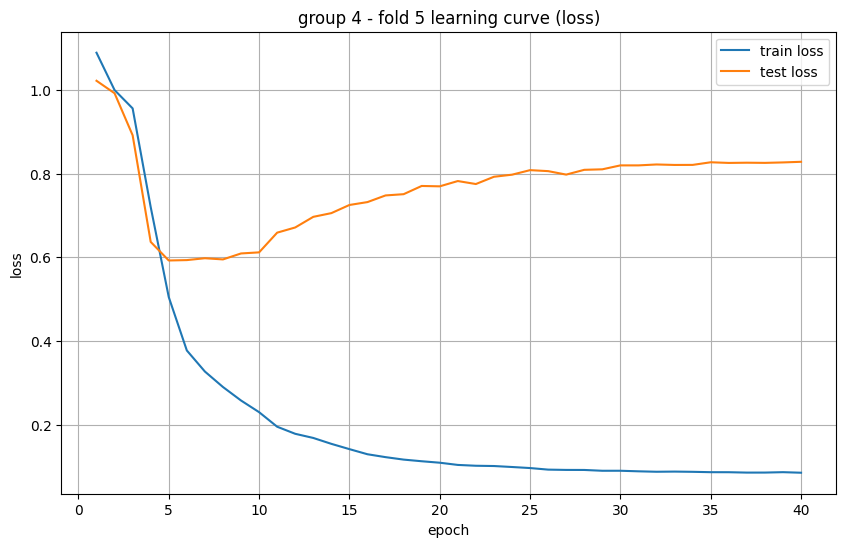

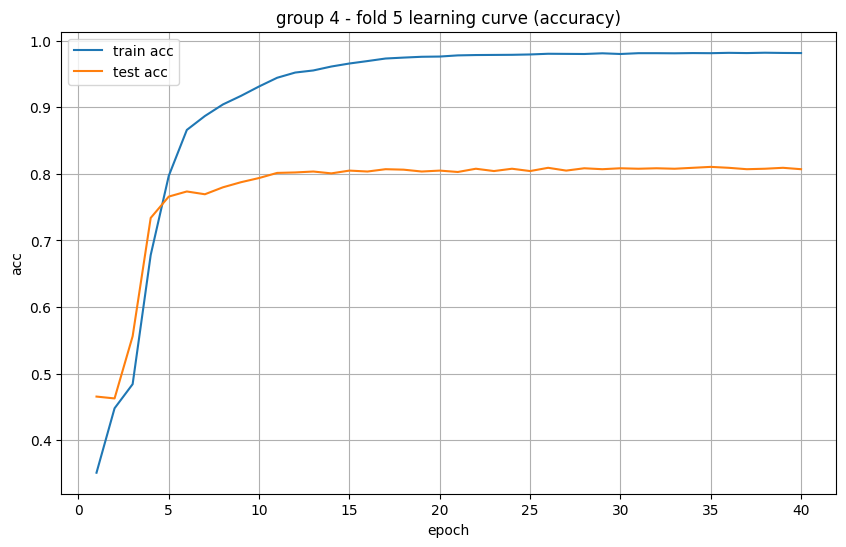

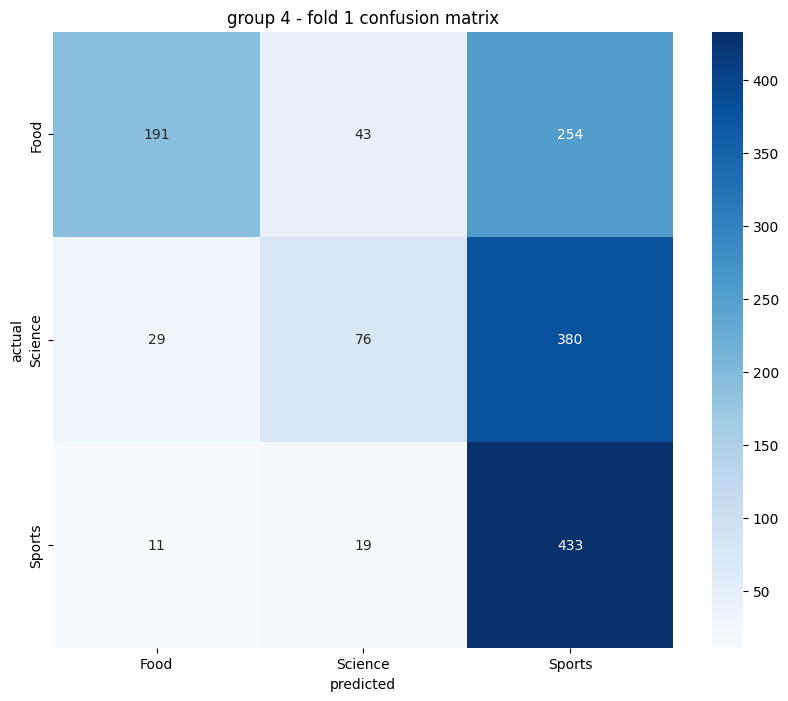

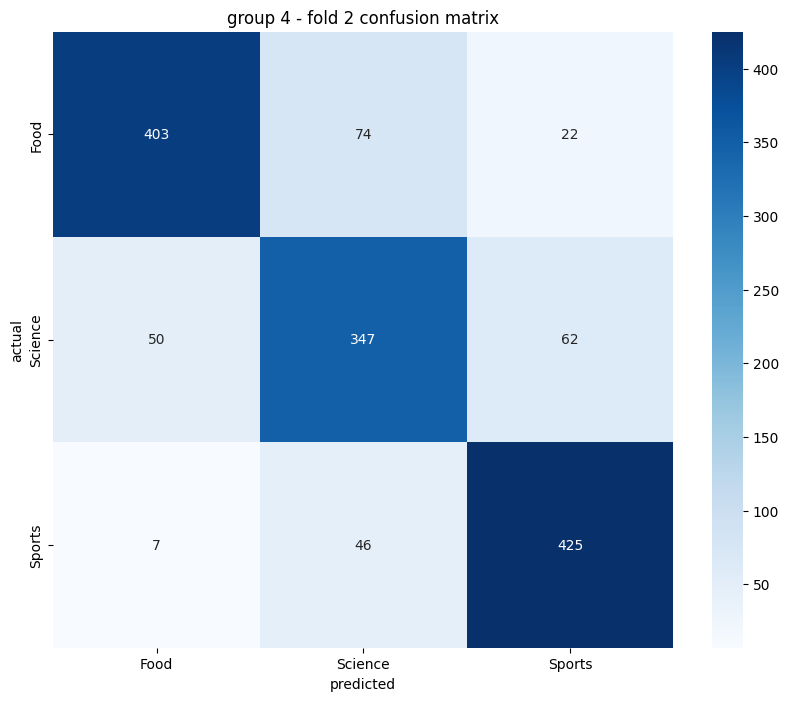

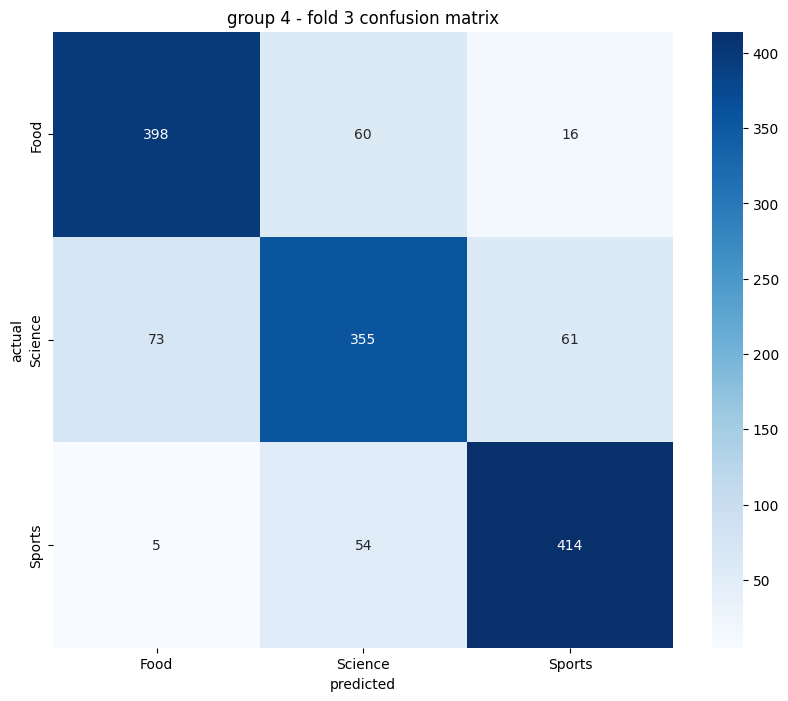

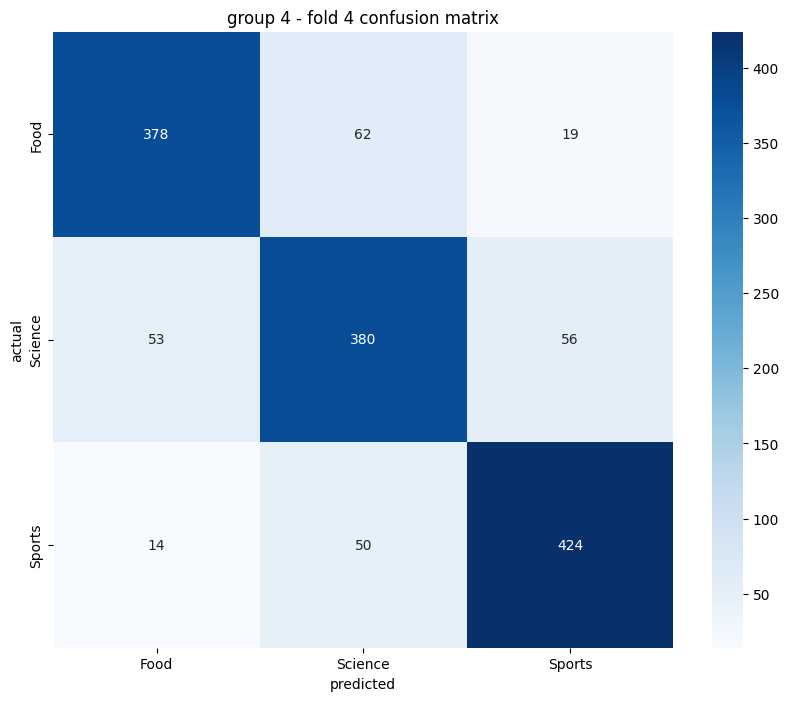

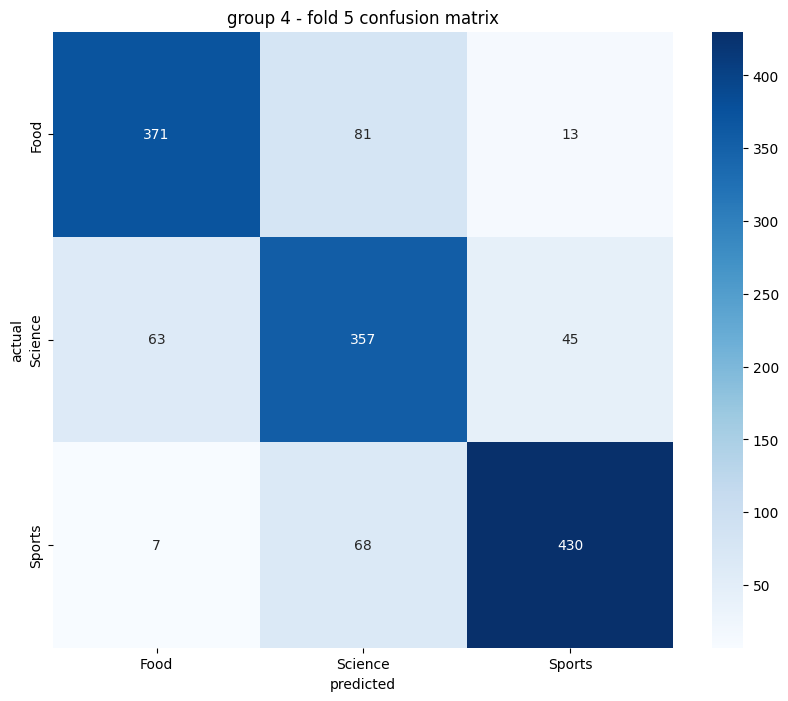


group 5 처리 중...

  fold 1/5 처리 중...
    epoch 1/40: train loss: 1.1006, train acc: 0.3368
                               test loss: 1.1016, test acc: 0.3212
    epoch 5/40: train loss: 0.5245, train acc: 0.7988
                               test loss: 0.5584, test acc: 0.7887
    epoch 10/40: train loss: 0.2432, train acc: 0.9242
                               test loss: 0.5304, test acc: 0.8258
    epoch 15/40: train loss: 0.1649, train acc: 0.9512
                               test loss: 0.6670, test acc: 0.8188
    epoch 20/40: train loss: 0.1324, train acc: 0.9661
                               test loss: 0.7038, test acc: 0.8265
    epoch 25/40: train loss: 0.1142, train acc: 0.9711
                               test loss: 0.7444, test acc: 0.8237
    epoch 30/40: train loss: 0.1089, train acc: 0.9736
                               test loss: 0.7600, test acc: 0.8230
    epoch 35/40: train loss: 0.1055, train acc: 0.9757
                               test loss: 0.7719, test a

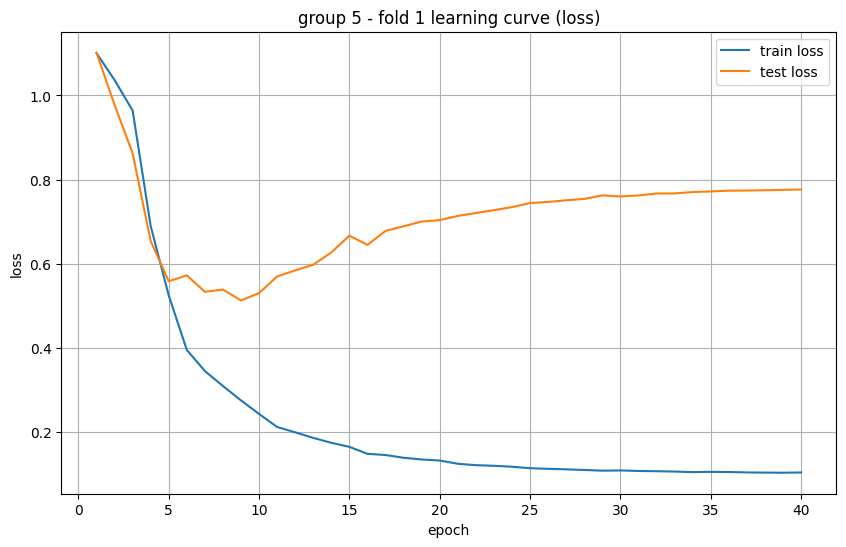

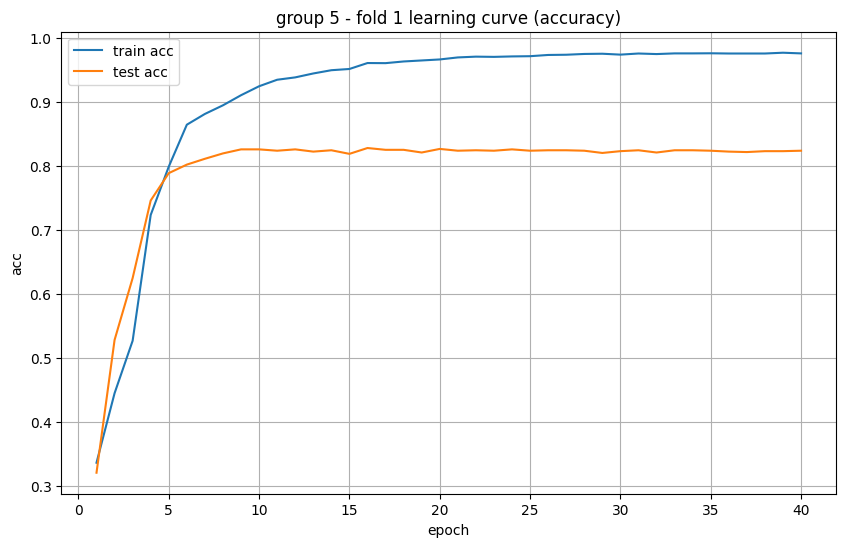

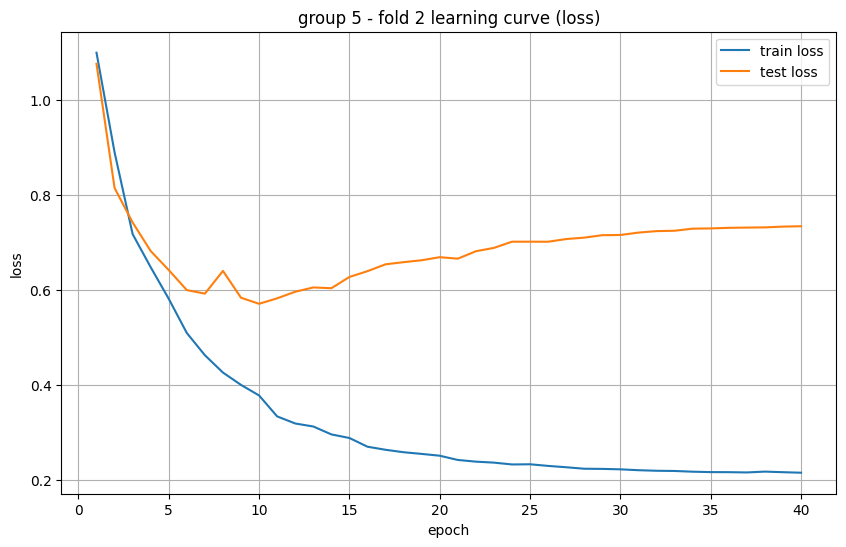

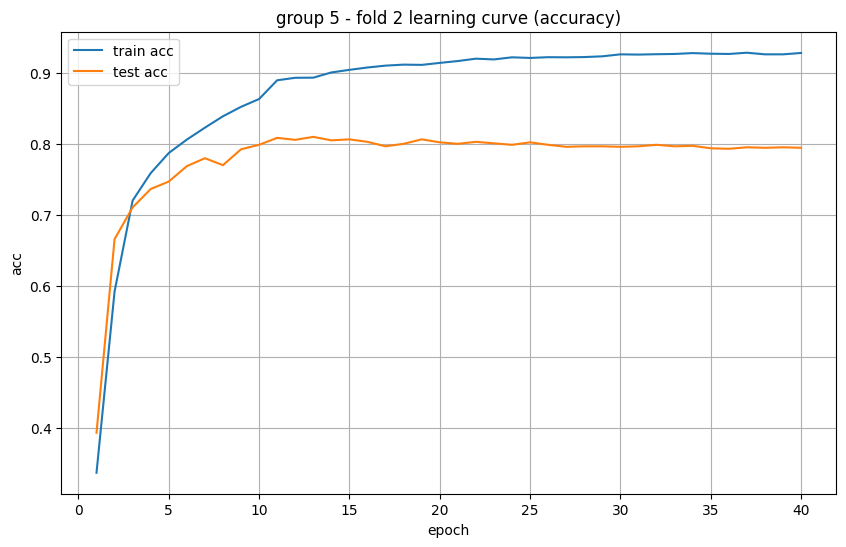

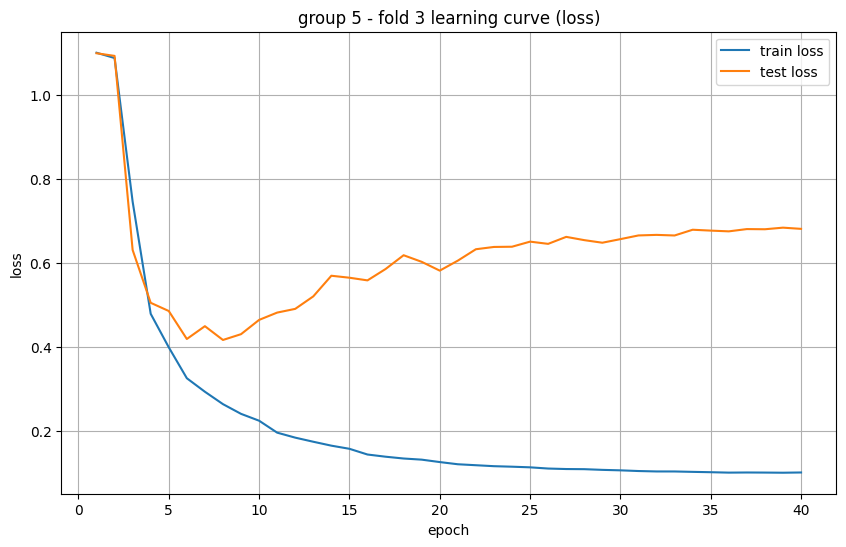

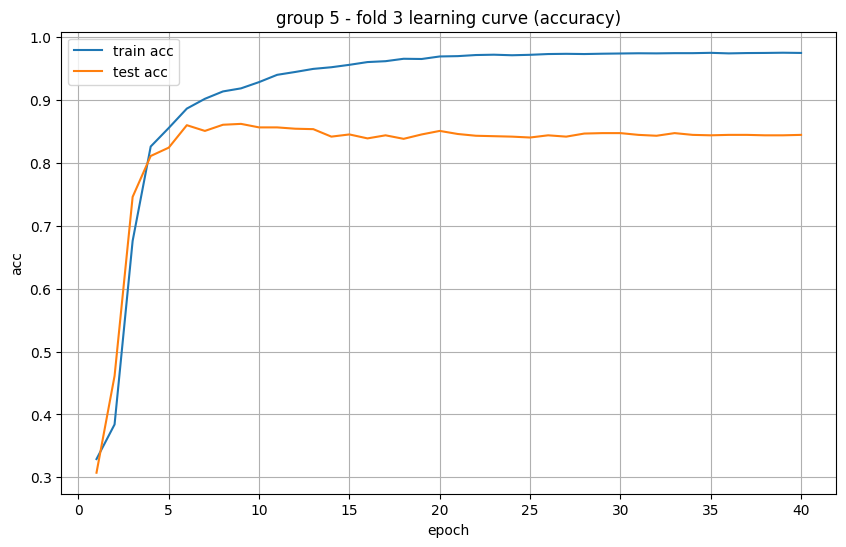

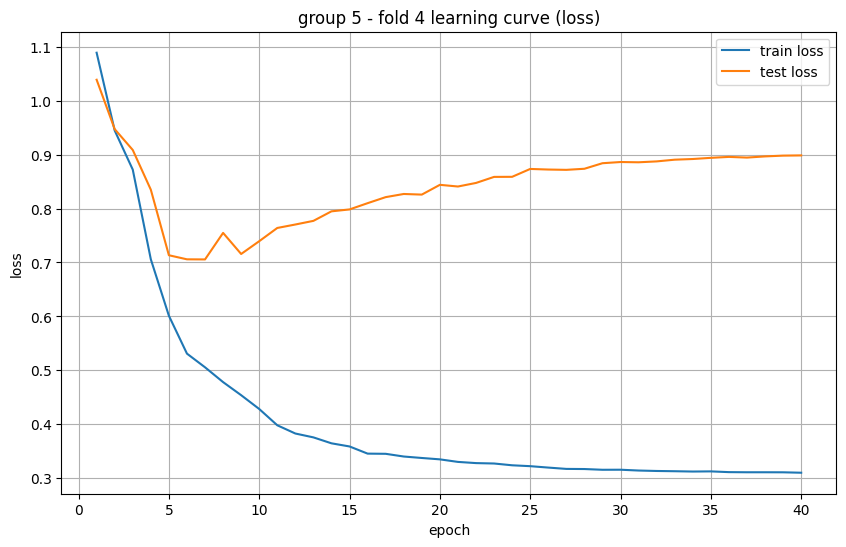

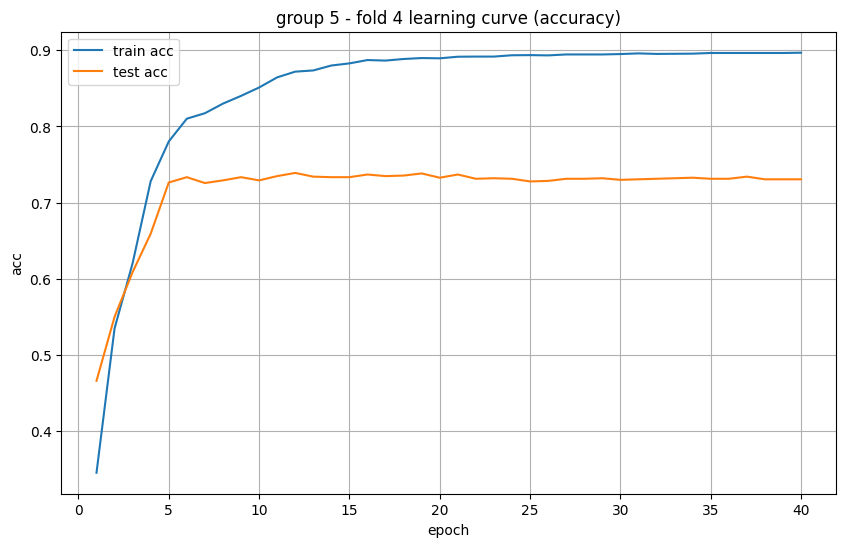

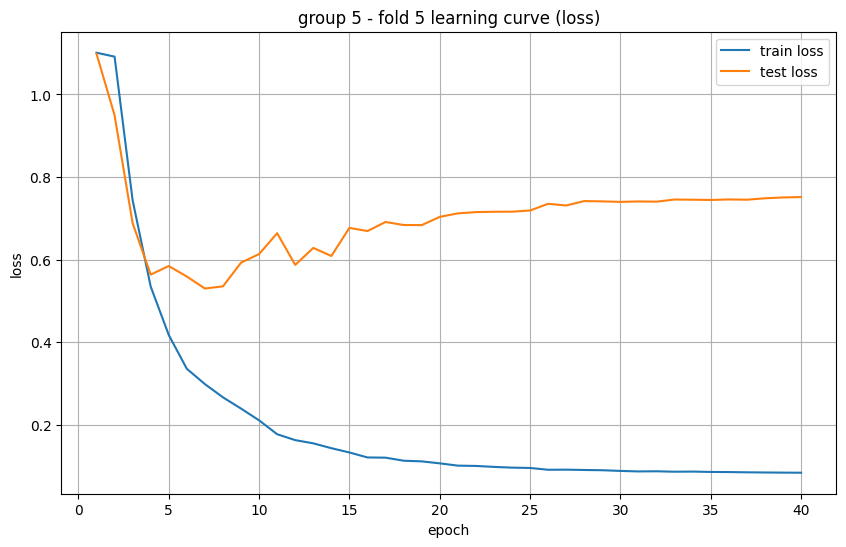

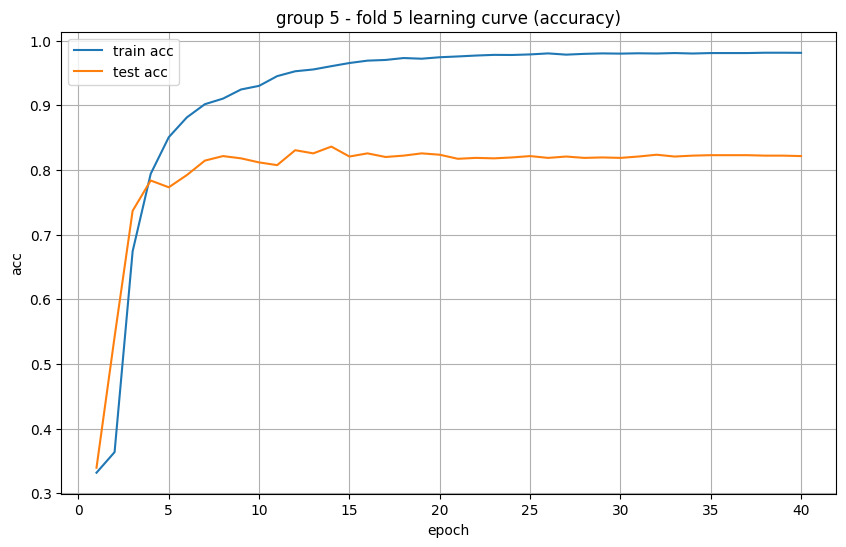

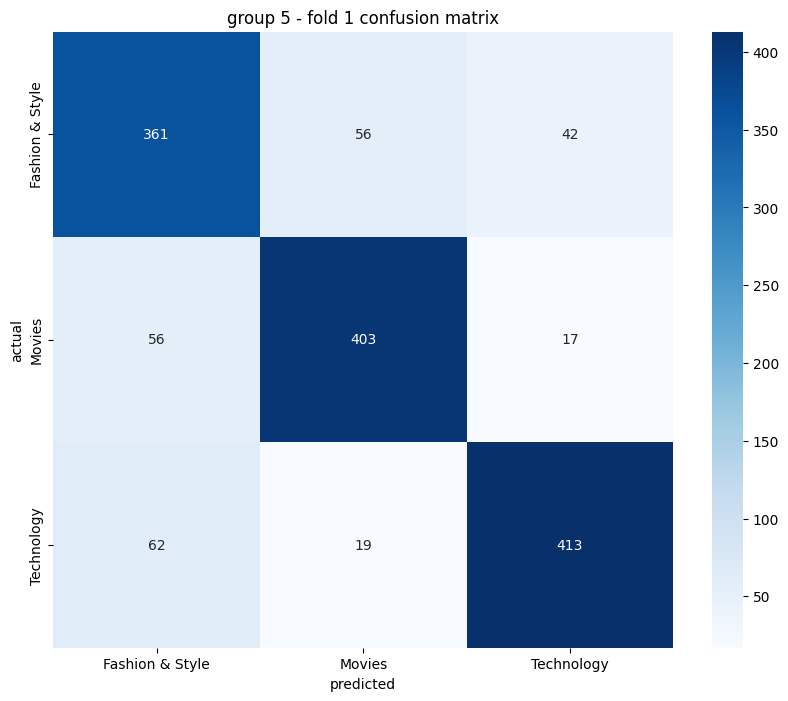

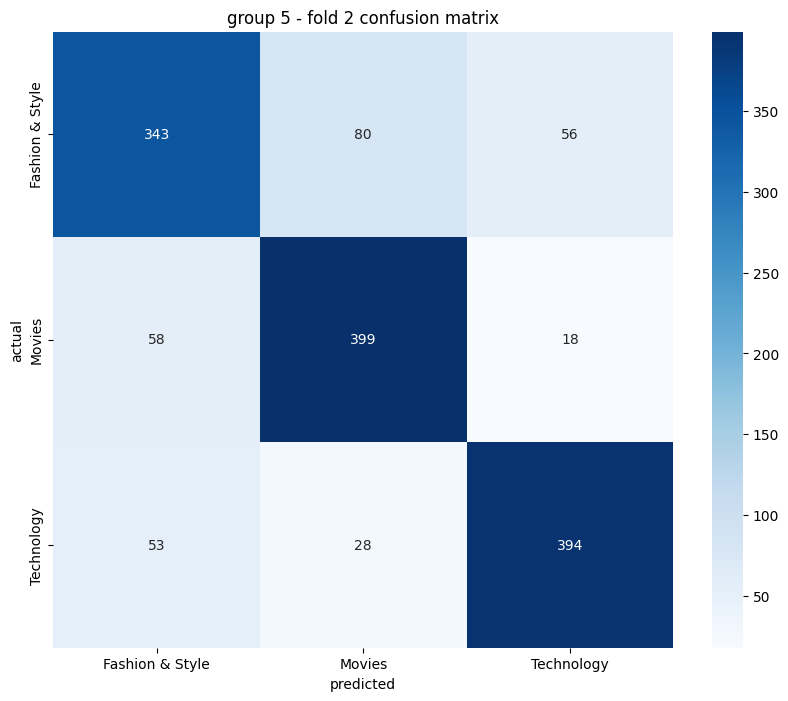

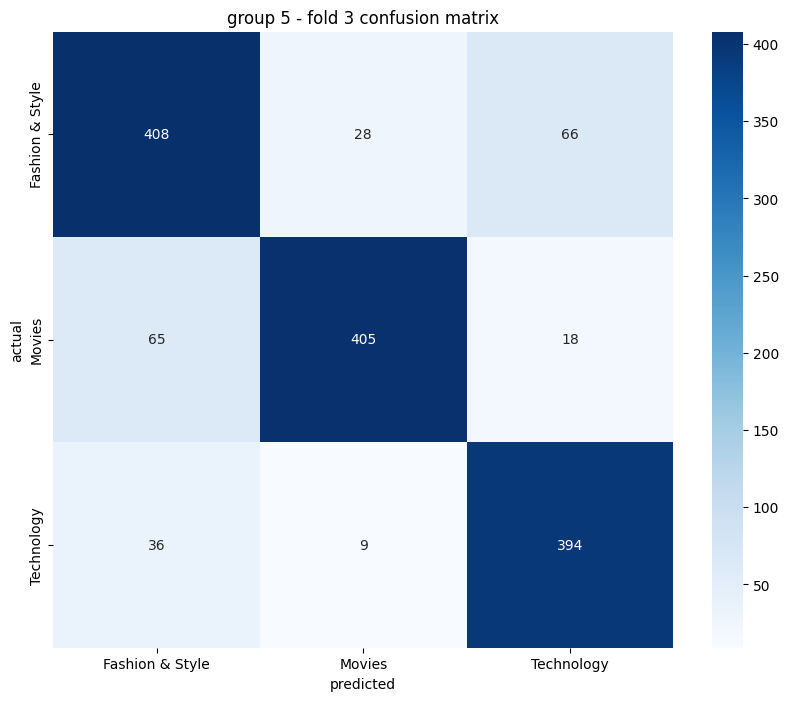

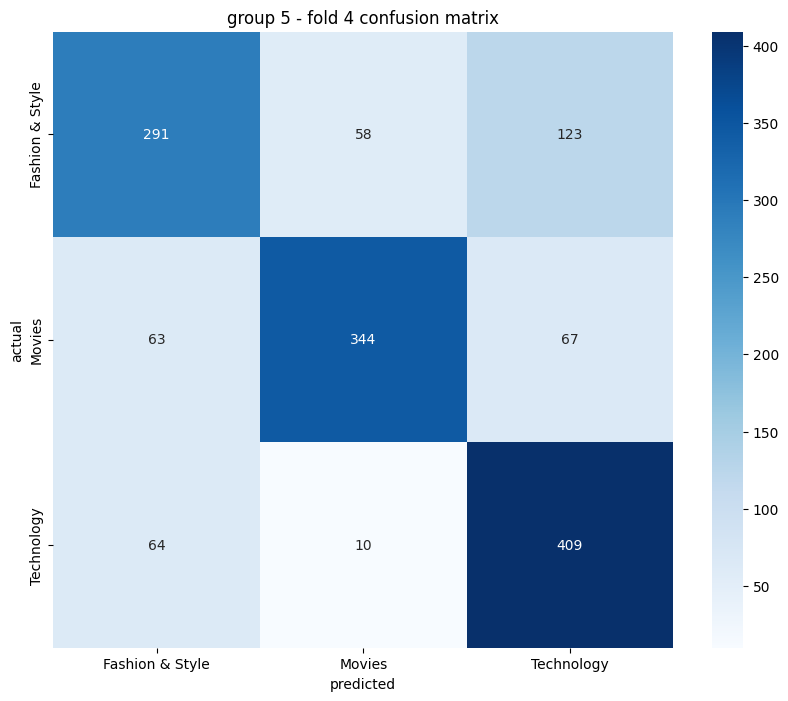

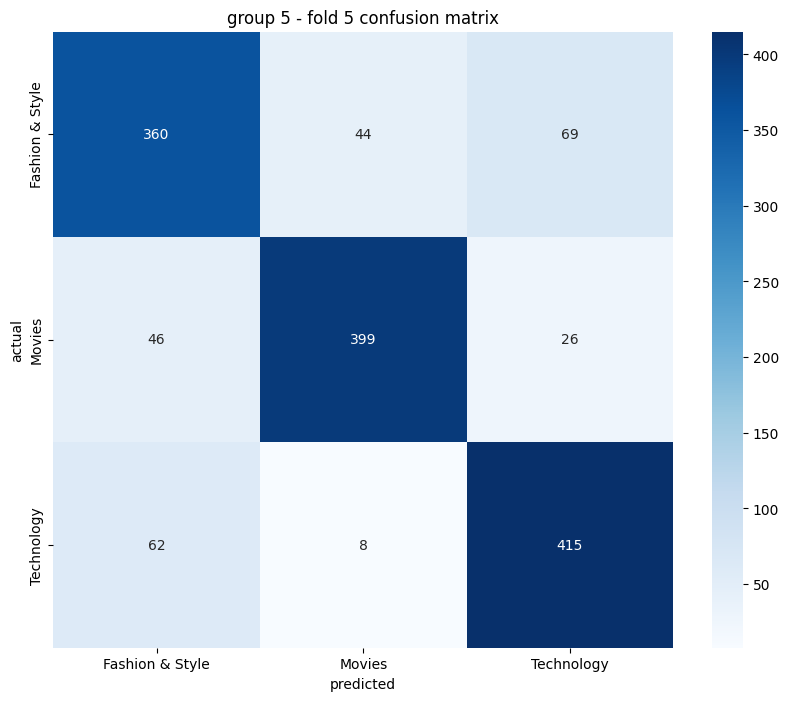


group 6 처리 중...

  fold 1/5 처리 중...
    epoch 1/40: train loss: 1.1023, train acc: 0.3416
                               test loss: 1.0991, test acc: 0.3389
    epoch 5/40: train loss: 0.8419, train acc: 0.6589
                               test loss: 0.8609, test acc: 0.6451
    epoch 10/40: train loss: 0.6900, train acc: 0.7455
                               test loss: 0.8607, test acc: 0.6698
    epoch 15/40: train loss: 0.6186, train acc: 0.7707
                               test loss: 0.8945, test acc: 0.6793
    epoch 20/40: train loss: 0.5891, train acc: 0.7780
                               test loss: 0.9074, test acc: 0.6793
    epoch 25/40: train loss: 0.5719, train acc: 0.7807
                               test loss: 0.9228, test acc: 0.6756
    epoch 30/40: train loss: 0.5620, train acc: 0.7840
                               test loss: 0.9271, test acc: 0.6764
    epoch 35/40: train loss: 0.5581, train acc: 0.7847
                               test loss: 0.9394, test a

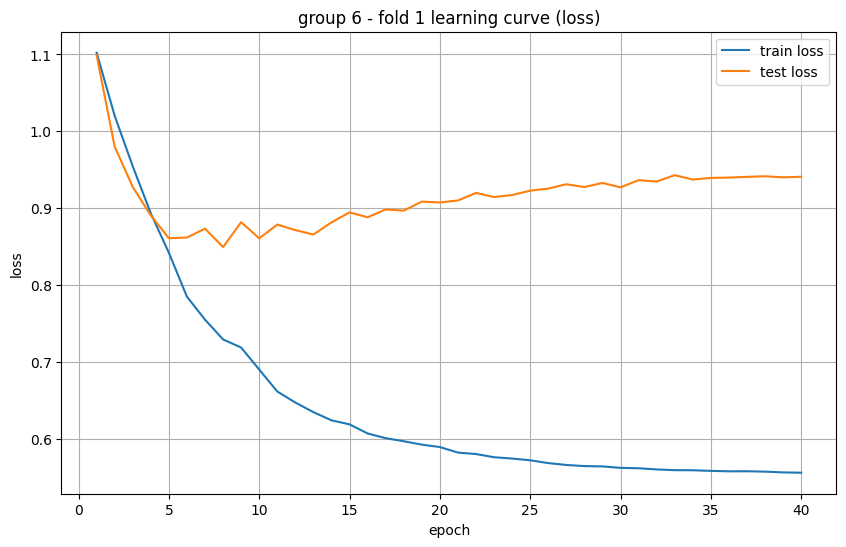

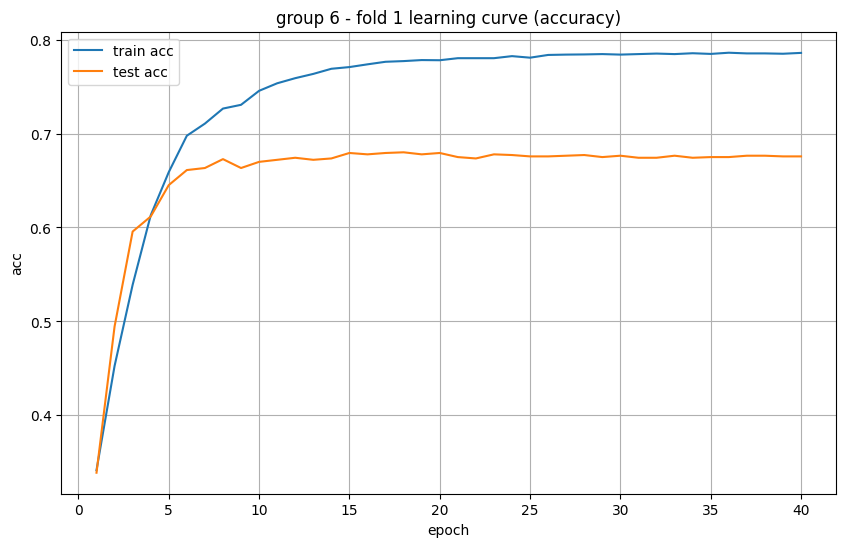

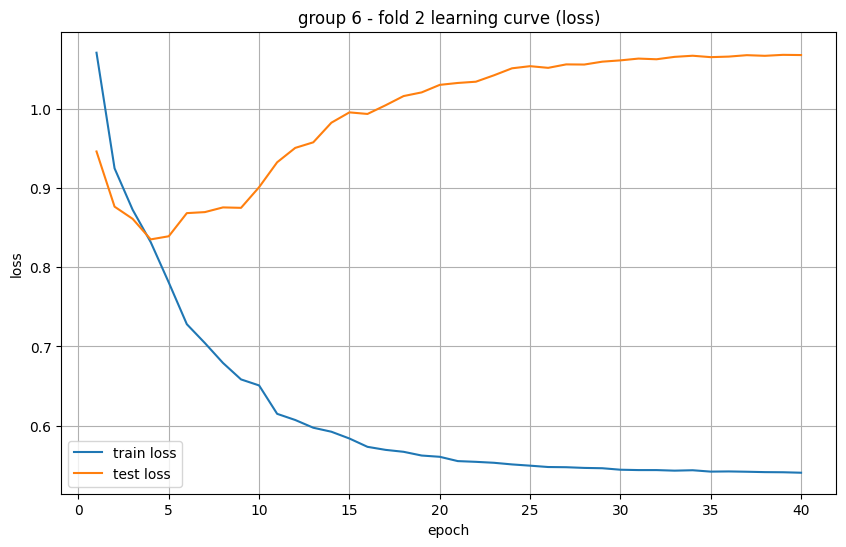

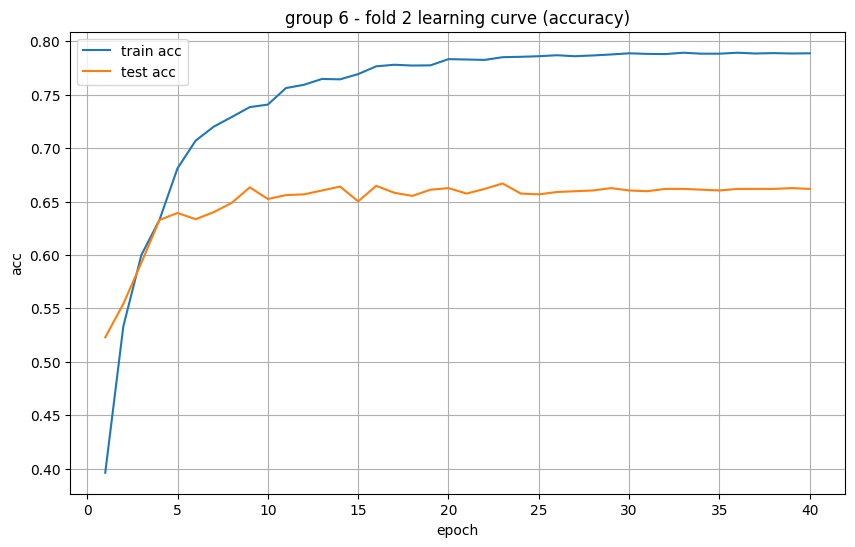

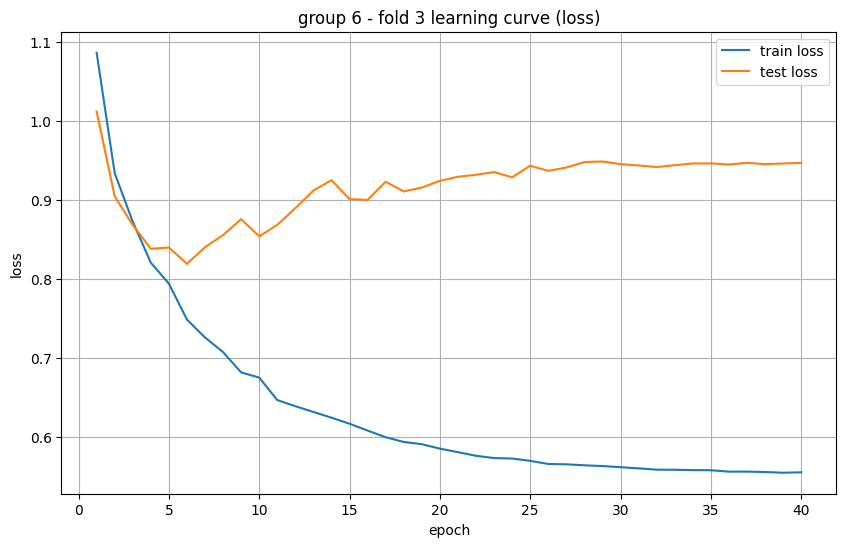

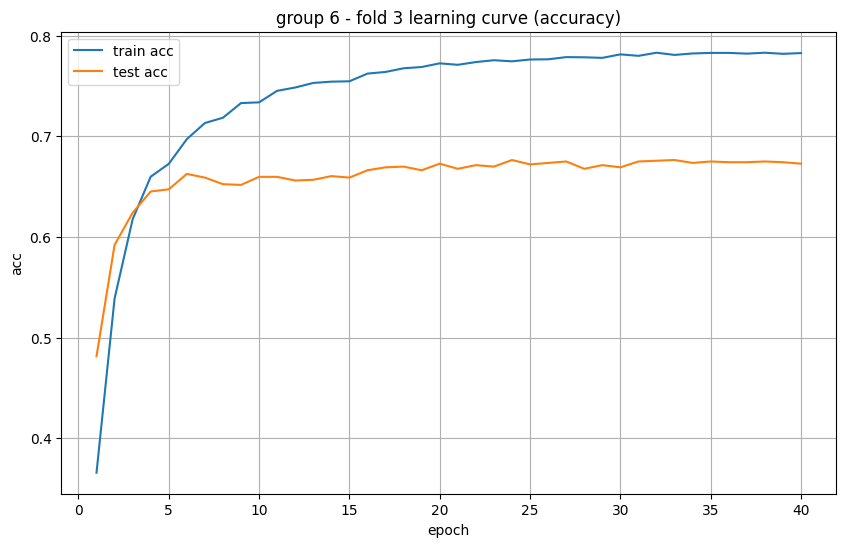

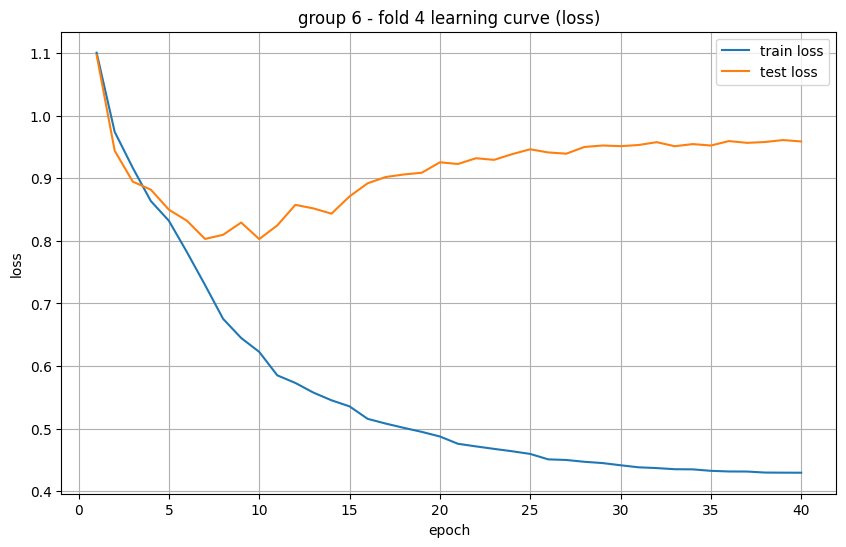

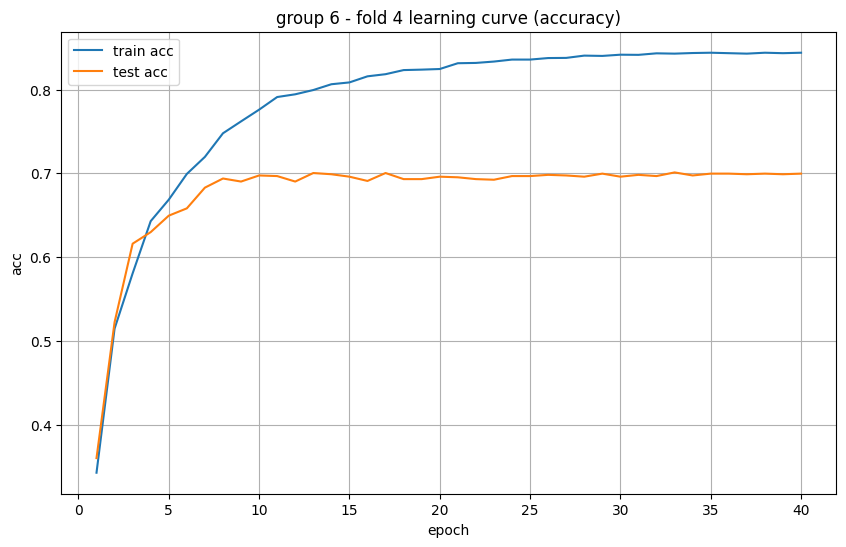

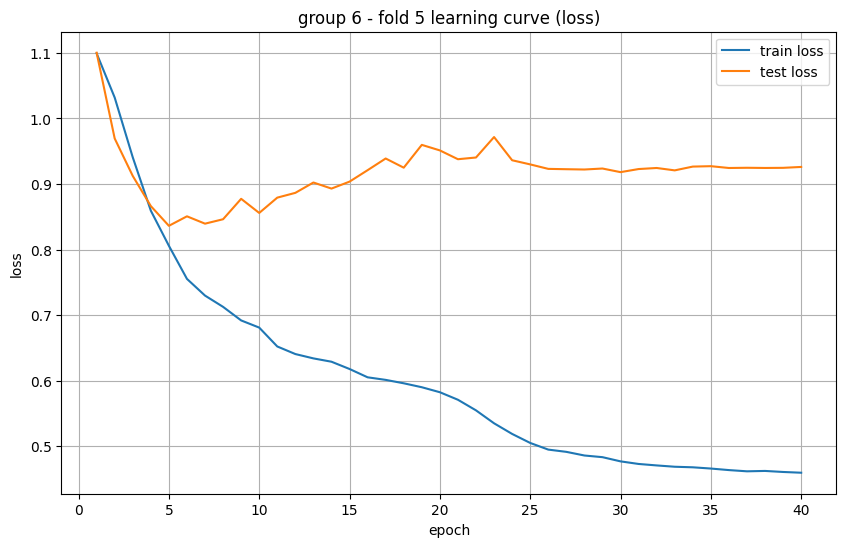

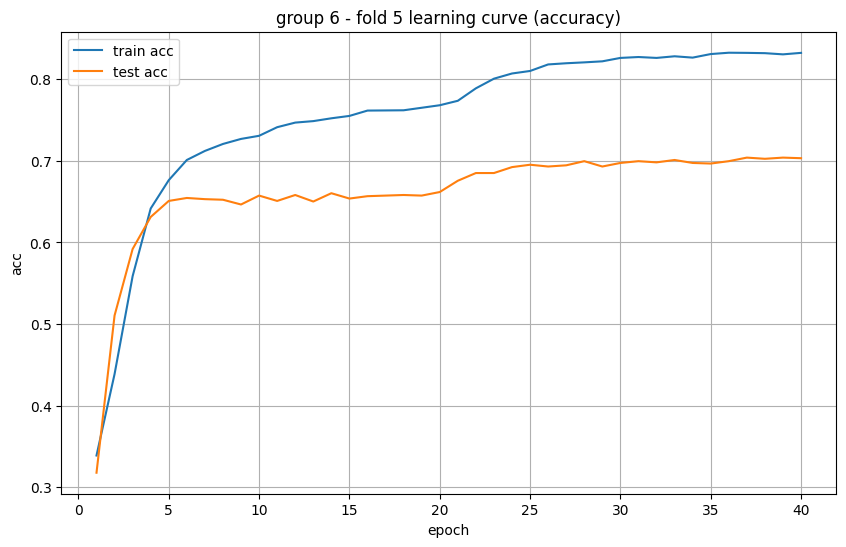

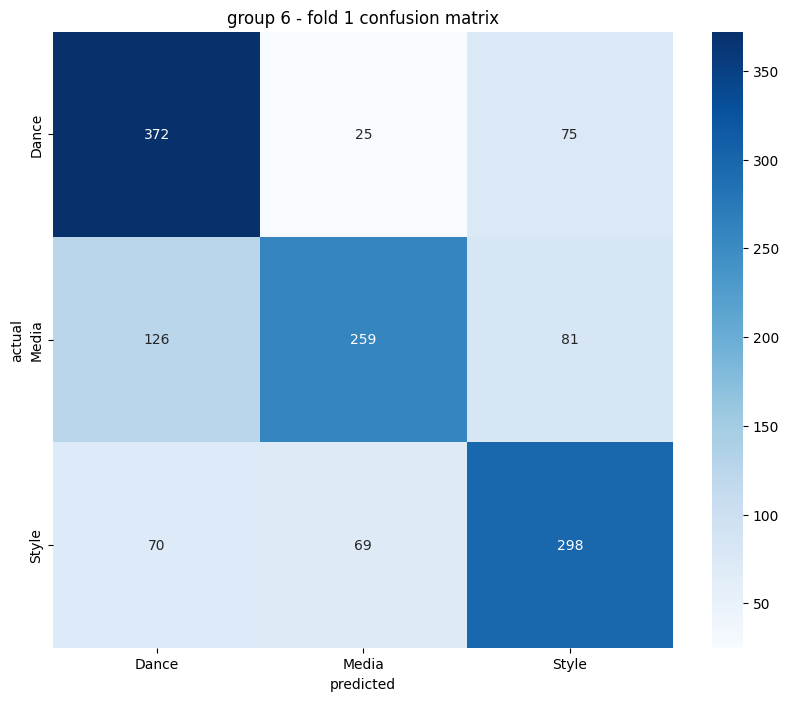

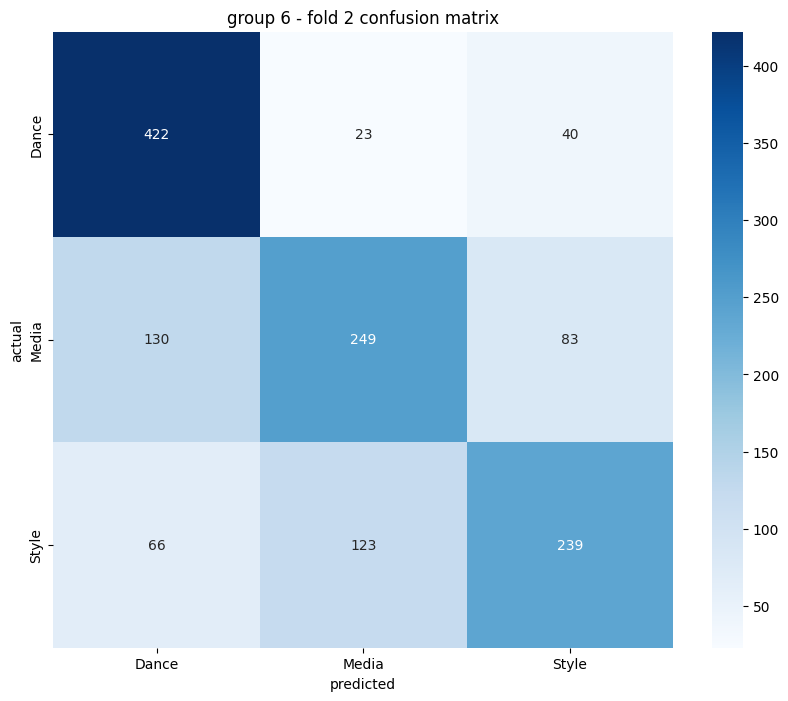

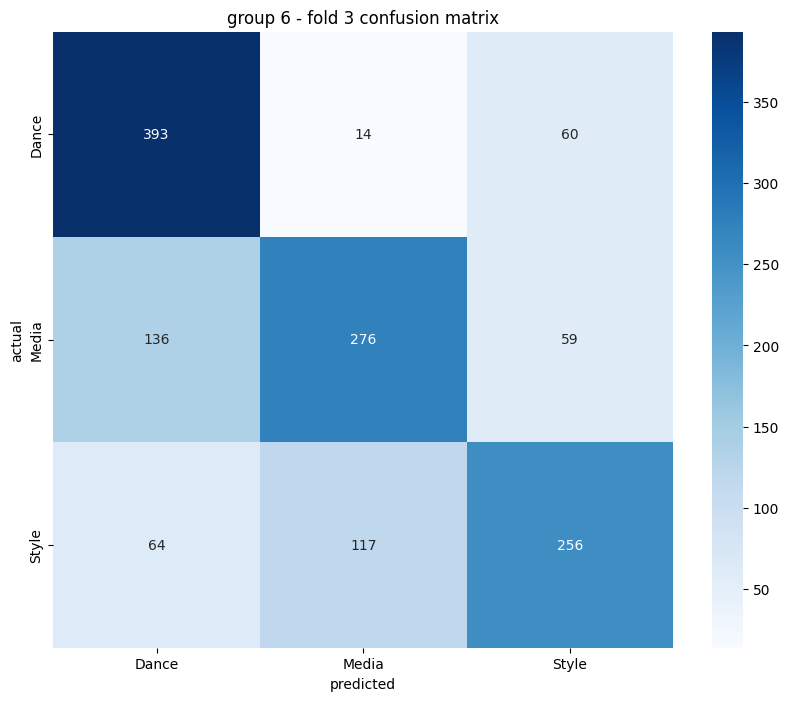

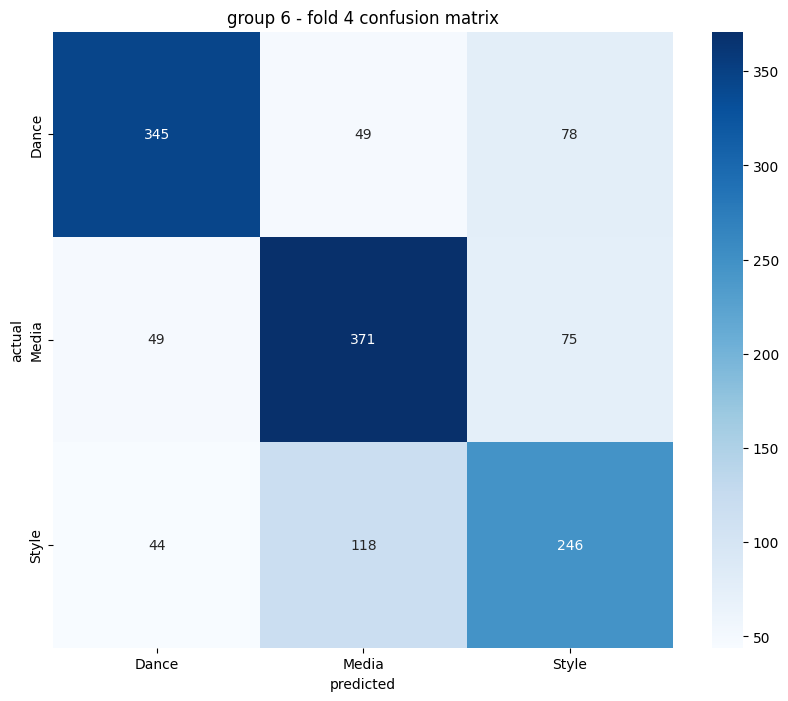

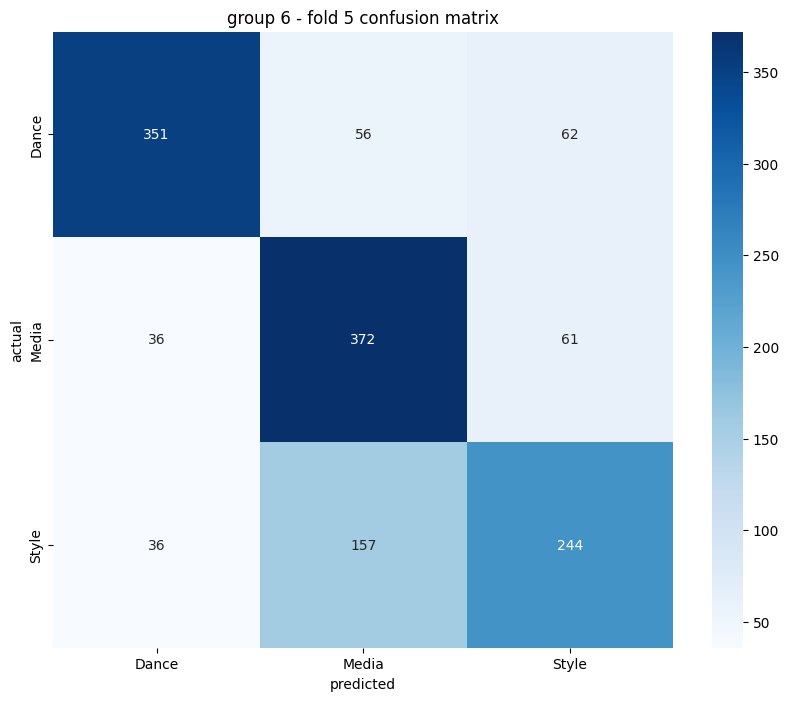


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.8171
  폴드 1: 테스트 정확도 = 0.8258
  폴드 2: 테스트 정확도 = 0.8313
  폴드 3: 테스트 정확도 = 0.7817
  폴드 4: 테스트 정확도 = 0.8161
  폴드 5: 테스트 정확도 = 0.8305

그룹 2 - 평균 테스트 정확도: 0.7398
  폴드 1: 테스트 정확도 = 0.7702
  폴드 2: 테스트 정확도 = 0.7633
  폴드 3: 테스트 정확도 = 0.6471
  폴드 4: 테스트 정확도 = 0.7410
  폴드 5: 테스트 정확도 = 0.7776

그룹 3 - 평균 테스트 정확도: 0.8068
  폴드 1: 테스트 정확도 = 0.7891
  폴드 2: 테스트 정확도 = 0.8188
  폴드 3: 테스트 정확도 = 0.8022
  폴드 4: 테스트 정확도 = 0.8354
  폴드 5: 테스트 정확도 = 0.7884

그룹 4 - 평균 테스트 정확도: 0.7497
  폴드 1: 테스트 정확도 = 0.4875
  폴드 2: 테스트 정확도 = 0.8182
  폴드 3: 테스트 정확도 = 0.8127
  폴드 4: 테스트 정확도 = 0.8231
  폴드 5: 테스트 정확도 = 0.8070

그룹 5 - 평균 테스트 정확도: 0.8031
  폴드 1: 테스트 정확도 = 0.8237
  폴드 2: 테스트 정확도 = 0.7950
  폴드 3: 테스트 정확도 = 0.8446
  폴드 4: 테스트 정확도 = 0.7306
  폴드 5: 테스트 정확도 = 0.8216

그룹 6 - 평균 테스트 정확도: 0.6826
  폴드 1: 테스트 정확도 = 0.6756
  폴드 2: 테스트 정확도 = 0.6618
  폴드 3: 테스트 정확도 = 0.6727
  폴드 4: 테스트 정확도 = 0.6996
  폴드 5: 테스트 정확도 = 0.7033


In [8]:
EPOCHS = 40
BATCH_SIZE = 32
K_FOLDS = 5
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수
LR = 5e-4

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = LR
            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    # val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    # with open(val_loader_save_path, 'wb') as f:
    #     pickle.dump(best_valid_loader, f) 
    # print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")

In [ ]:
import pickle

file_path = "/home/youlee/perceiver/perceiver/loader/text_val_loader_1.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

type_of_data = type(data)
if hasattr(data, 'shape'):
    data_shape = data.shape
else:
    try:
        data_shape = (len(data), len(data[0]))
    except Exception as e:
        data_shape = f"Cannot determine shape: {e}"

type_of_data, data_shape


(torch.utils.data.dataloader.DataLoader,
 "Cannot determine shape: 'DataLoader' object is not subscriptable")

In [10]:
for batch in data:
  
    if isinstance(batch, dict):
        print({key: value.shape for key, value in batch.items()})

    elif isinstance(batch, tuple):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")
    break  

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
